In [5]:
import numpy as np

In [6]:
filepath="../output/amlt_logs/config_281/sampling_results_1perc_Temp_2k_dirichlet/20250828_032531_single_1fcd_C_trajectory_analysis.npz"

data = np.load(filepath) 

In [7]:
data.keys()

KeysView(NpzFile '../output/amlt_logs/config_281/sampling_results_1perc_Temp_2k_dirichlet/20250828_032531_single_1fcd_C_trajectory_analysis.npz' with keys: 1fcd.C_model_predictions, 1fcd.C_current_states, 1fcd.C_ground_truth)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Amino acid mapping
aa_to_idx = {
    'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9,
    'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19
}

idx_to_aa = {v: k for k, v in aa_to_idx.items()}
aa_names = [idx_to_aa[i] for i in range(20)]

print("Data loaded and imports complete!")

Data loaded and imports complete!


In [9]:
# Inspect the data structure
print("Available keys:")
for key in data.keys():
    print(f"  {key}: shape {data[key].shape}")
    
# Extract protein ID
protein_id = list(data.keys())[0].split('_')[0]  # Should be "1fcd.C"
print(f"\nProtein ID: {protein_id}")

# Extract data
predictions = data[f'{protein_id}_model_predictions']  # Shape: [timesteps, positions, 20_amino_acids]
current_states = data[f'{protein_id}_current_states']   # Shape: [timesteps, positions] - amino acid indices
ground_truth = data[f'{protein_id}_ground_truth']       # Shape: [positions] - ground truth amino acid indices

print(f"\nData shapes:")
print(f"  Predictions: {predictions.shape}")
print(f"  Current states: {current_states.shape}")
print(f"  Ground truth: {ground_truth.shape}")

# Use the final timestep predictions
final_predictions = predictions[-1]  # Shape: [positions, 20]
print(f"  Final predictions: {final_predictions.shape}")

Available keys:
  1fcd.C_model_predictions: shape (19, 174, 21)
  1fcd.C_current_states: shape (19, 174, 21)
  1fcd.C_ground_truth: shape (174, 21)

Protein ID: 1fcd.C

Data shapes:
  Predictions: (19, 174, 21)
  Current states: (19, 174, 21)
  Ground truth: (174, 21)
  Final predictions: (174, 21)


In [10]:
# Fix data format issues
print("Checking data format...")

# Check if ground truth is one-hot encoded
print(f"Ground truth sample (first 5 positions):")
print(ground_truth[:5])
print(f"Ground truth sum per position (should be 1 if one-hot): {ground_truth[:5].sum(axis=1)}")

# Convert one-hot to indices if needed
if len(ground_truth.shape) > 1 and ground_truth.shape[1] > 1:
    print("Converting one-hot ground truth to indices...")
    ground_truth_indices = np.argmax(ground_truth, axis=1)
else:
    ground_truth_indices = ground_truth

print(f"Ground truth indices shape: {ground_truth_indices.shape}")
print(f"Ground truth indices sample: {ground_truth_indices[:10]}")

# Handle 21 vs 20 dimensions (remove mask token if present)
if final_predictions.shape[1] == 21:
    print("Removing mask token (assuming last dimension)...")
    final_predictions = final_predictions[:, :20]  # Keep only amino acid probabilities
    
print(f"Final predictions shape after processing: {final_predictions.shape}")

# Update amino acid mappings to handle the data properly
n_positions = len(ground_truth_indices)
print(f"Number of positions: {n_positions}")

Checking data format...
Ground truth sample (first 5 positions):
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Ground truth sum per position (should be 1 if one-hot): [1. 1. 1. 1. 1.]
Converting one-hot ground truth to indices...
Ground truth indices shape: (174,)
Ground truth indices sample: [ 3 12 16  0  3 10  9 16 11 11]
Removing mask token (assuming last dimension)...
Final predictions shape after processing: (174, 20)
Number of positions: 174


In [11]:
# Load B-factor data
pkl_path = "../datasets/cath-4.2/chain_set_map_with_b_factors_dssp.pkl"
with open(pkl_path, 'rb') as f:
    b_factor_data = pickle.load(f)

print(f"Available proteins in B-factor data: {len(b_factor_data)} proteins")
print(f"Looking for protein: {protein_id}")

if protein_id in b_factor_data:
    b_factors = b_factor_data[protein_id]['b_factors']
    print(f"B-factors found! Shape: {b_factors.shape}")
    print(f"B-factor range: {b_factors.min():.2f} to {b_factors.max():.2f}")
else:
    print(f"Warning: {protein_id} not found in B-factor data")
    print(f"Available keys starting with '1fcd': {[k for k in b_factor_data.keys() if k.startswith('1fcd')]}")
    # Use first available key or create dummy data
    available_keys = [k for k in b_factor_data.keys() if k.startswith('1fcd')]
    if available_keys:
        actual_key = available_keys[0]
        b_factors = b_factor_data[actual_key]['b_factors']
        print(f"Using {actual_key} instead")
    else:
        # Create dummy B-factors if not found
        b_factors = np.random.uniform(20, 80, len(ground_truth))
        print("Using dummy B-factors")

Available proteins in B-factor data: 21668 proteins
Looking for protein: 1fcd.C
B-factors found! Shape: (174,)
B-factor range: 16.58 to 64.91


/tmp/ipykernel_2188253/992422404.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


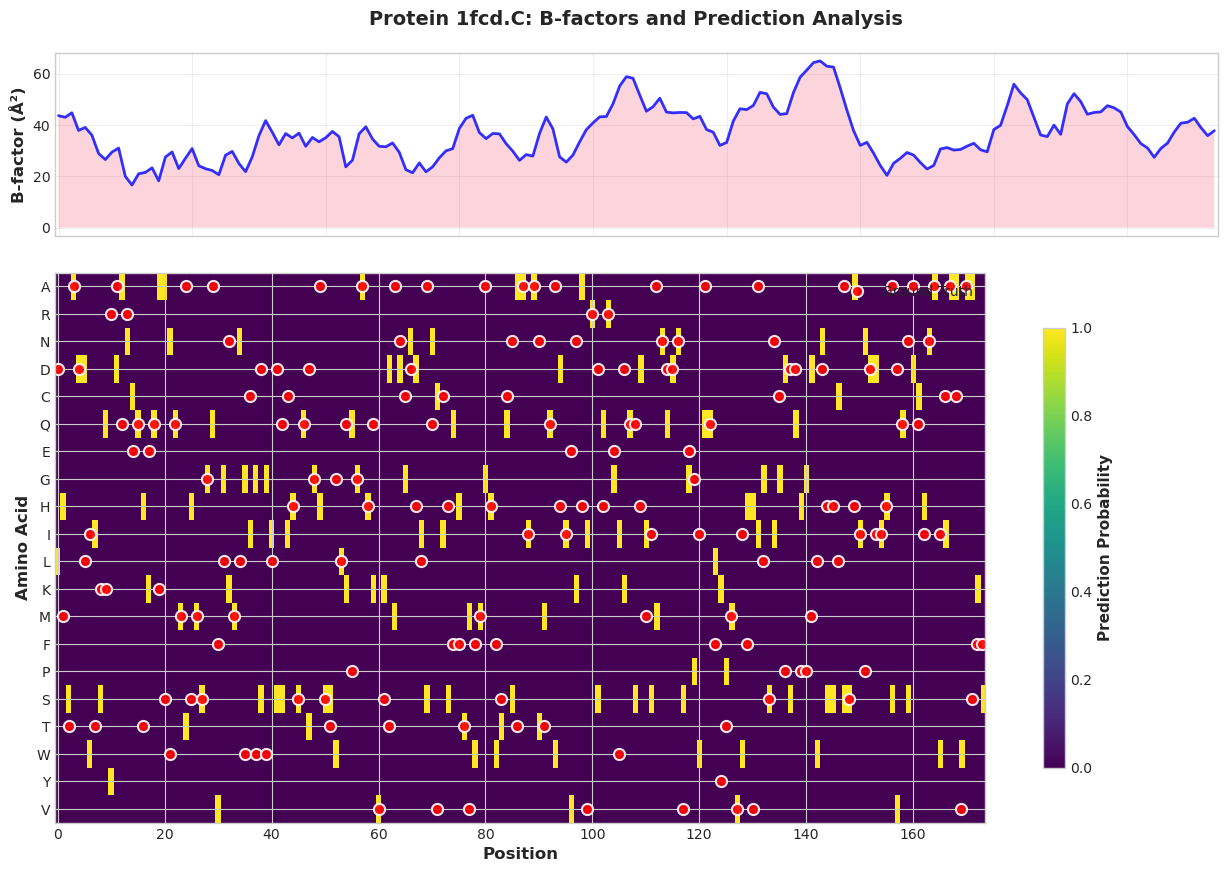

In [13]:
# Create the comprehensive visualization
def create_prediction_analysis_plot(predictions, ground_truth_indices, b_factors, protein_id):
    """
    Create a two-panel plot:
    - Top: B-factor line plot
    - Bottom: Prediction probability heatmap with ground truth dots
    """
    
    # Ensure data alignment
    n_positions = len(ground_truth_indices)
    b_factors = b_factors[:n_positions]  # Trim if necessary
    predictions = predictions[:n_positions]  # Trim if necessary
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), 
                                   gridspec_kw={'height_ratios': [1, 3], 'hspace': 0.1})
    
    # Top panel: B-factor line plot
    positions = np.arange(n_positions)
    ax1.plot(positions, b_factors, 'b-', linewidth=2, alpha=0.8)
    ax1.fill_between(positions, b_factors, alpha=0.3)
    ax1.set_ylabel('B-factor (Å²)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Protein {protein_id}: B-factors and Prediction Analysis', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(-0.5, n_positions - 0.5)
    
    # Remove x-axis labels from top plot (will be shared with bottom)
    ax1.set_xticklabels([])
    
    # Bottom panel: Prediction heatmap
    # Transpose predictions for proper orientation (amino acids on y-axis, positions on x-axis)
    heatmap_data = predictions.T
    
    # Create heatmap
    im = ax2.imshow(heatmap_data, cmap='viridis', aspect='auto', interpolation='nearest')
    
    # Add ground truth dots
    for pos, true_aa_idx in enumerate(ground_truth_indices):
        ax2.plot(pos, true_aa_idx, 'ro', markersize=8, markeredgecolor='white', 
                markeredgewidth=1.5, alpha=0.9)
    
    # Customize bottom panel
    ax2.set_xlabel('Position', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Amino Acid', fontsize=12, fontweight='bold')
    ax2.set_yticks(range(20))
    ax2.set_yticklabels(aa_names)
    ax2.set_xlim(-0.5, n_positions - 0.5)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
    cbar.set_label('Prediction Probability', fontsize=11, fontweight='bold')
    
    # Align x-axes
    ax1.set_xlim(ax2.get_xlim())
    
    # Add legend for ground truth dots
    ax2.plot([], [], 'ro', markersize=8, markeredgecolor='white', 
             markeredgewidth=1.5, label='Ground Truth', alpha=0.9)
    ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Create the plot
fig, (ax1, ax2) = create_prediction_analysis_plot(final_predictions, ground_truth_indices, b_factors, protein_id)
plt.show()

In [15]:
# Quantitative analysis
def analyze_prediction_accuracy(predictions, ground_truth_indices):
    """Analyze prediction accuracy and confidence"""
    
    # Get predicted amino acids (highest probability)
    predicted_aa = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_aa == ground_truth_indices)
    
    # Get confidence (probability of ground truth)
    ground_truth_probs = predictions[np.arange(len(ground_truth_indices)), ground_truth_indices]
    
    # Get prediction confidence (max probability)
    prediction_confidence = np.max(predictions, axis=1)
    
    return {
        'accuracy': accuracy,
        'predicted_aa': predicted_aa,
        'ground_truth_probs': ground_truth_probs,
        'prediction_confidence': prediction_confidence,
        'mean_gt_prob': np.mean(ground_truth_probs),
        'mean_pred_confidence': np.mean(prediction_confidence)
    }

# Perform analysis
analysis = analyze_prediction_accuracy(final_predictions, ground_truth_indices)

print("=== Prediction Analysis Results ===")
print(f"Overall Accuracy: {analysis['accuracy']:.3f} ({analysis['accuracy']*100:.1f}%)")
print(f"Mean Ground Truth Probability: {analysis['mean_gt_prob']:.3f}")
print(f"Mean Prediction Confidence: {analysis['mean_pred_confidence']:.3f}")

# Show positions where prediction differs from ground truth
incorrect_positions = np.where(analysis['predicted_aa'] != ground_truth_indices)[0]
print(f"\nIncorrect Predictions: {len(incorrect_positions)}/{len(ground_truth_indices)} positions")

if len(incorrect_positions) > 0:
    print("\nFirst 10 incorrect positions:")
    for i, pos in enumerate(incorrect_positions[:10]):
        true_aa = idx_to_aa[ground_truth_indices[pos]]
        pred_aa = idx_to_aa[analysis['predicted_aa'][pos]]
        gt_prob = analysis['ground_truth_probs'][pos]
        pred_conf = analysis['prediction_confidence'][pos]
        print(f"  Position {pos}: True={true_aa}, Pred={pred_aa}, GT_prob={gt_prob:.3f}, Pred_conf={pred_conf:.3f}")

=== Prediction Analysis Results ===
Overall Accuracy: 0.276 (27.6%)
Mean Ground Truth Probability: 0.276
Mean Prediction Confidence: 1.000

Incorrect Predictions: 126/174 positions

First 10 incorrect positions:
  Position 0: True=D, Pred=L, GT_prob=0.000, Pred_conf=1.000
  Position 1: True=M, Pred=H, GT_prob=0.000, Pred_conf=1.000
  Position 2: True=T, Pred=S, GT_prob=0.000, Pred_conf=1.000
  Position 5: True=L, Pred=D, GT_prob=0.000, Pred_conf=1.000
  Position 6: True=I, Pred=W, GT_prob=0.000, Pred_conf=1.000
  Position 7: True=T, Pred=I, GT_prob=0.000, Pred_conf=1.000
  Position 8: True=K, Pred=S, GT_prob=0.000, Pred_conf=1.000
  Position 9: True=K, Pred=Q, GT_prob=0.000, Pred_conf=1.000
  Position 10: True=R, Pred=Y, GT_prob=0.000, Pred_conf=1.000
  Position 11: True=A, Pred=D, GT_prob=0.000, Pred_conf=1.000


/tmp/ipykernel_2188253/2014573165.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_conf, p_pearson_conf = pearsonr(b_factors, prediction_confidence)
/tmp/ipykernel_2188253/2014573165.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_conf, p_spearman_conf = spearmanr(b_factors, prediction_confidence)



=== B-factor Correlation Analysis ===
B-factor vs Ground Truth Probability:
  Pearson r = -0.016, p = 8.305e-01
  Spearman ρ = -0.030, p = 6.973e-01

B-factor vs Prediction Confidence:
  Pearson r = nan, p = nan
  Spearman ρ = nan, p = nan


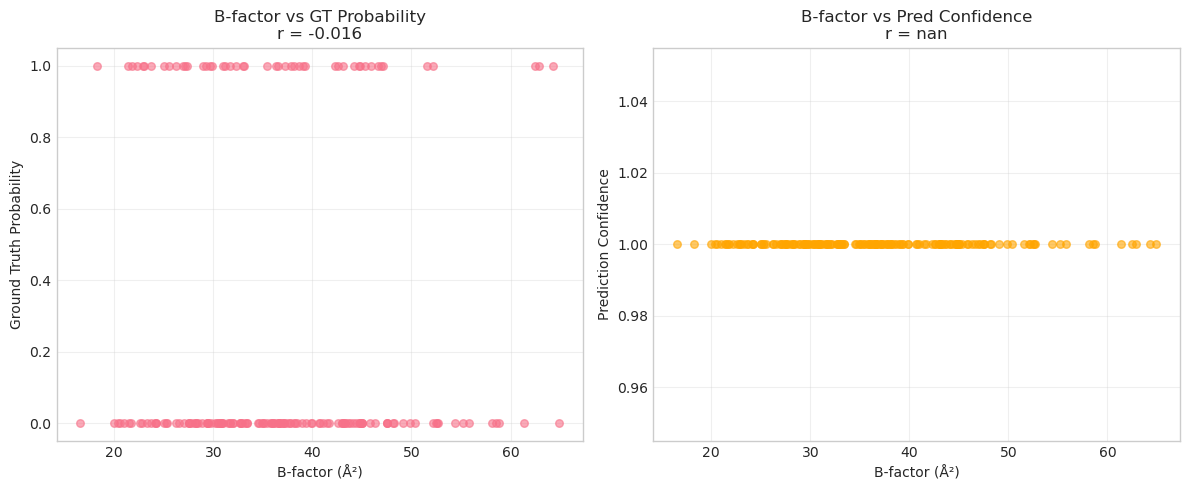

In [16]:
# B-factor correlation analysis
def analyze_bfactor_correlation(b_factors, ground_truth_probs, prediction_confidence):
    """Analyze correlation between B-factors and prediction metrics"""
    
    from scipy.stats import pearsonr, spearmanr
    
    # Calculate correlations
    pearson_gt, p_pearson_gt = pearsonr(b_factors, ground_truth_probs)
    spearman_gt, p_spearman_gt = spearmanr(b_factors, ground_truth_probs)
    
    pearson_conf, p_pearson_conf = pearsonr(b_factors, prediction_confidence)
    spearman_conf, p_spearman_conf = spearmanr(b_factors, prediction_confidence)
    
    return {
        'pearson_gt': (pearson_gt, p_pearson_gt),
        'spearman_gt': (spearman_gt, p_spearman_gt),
        'pearson_conf': (pearson_conf, p_pearson_conf),
        'spearman_conf': (spearman_conf, p_spearman_conf)
    }

# Perform correlation analysis
corr_analysis = analyze_bfactor_correlation(b_factors, 
                                          analysis['ground_truth_probs'],
                                          analysis['prediction_confidence'])

print("\n=== B-factor Correlation Analysis ===")
print(f"B-factor vs Ground Truth Probability:")
print(f"  Pearson r = {corr_analysis['pearson_gt'][0]:.3f}, p = {corr_analysis['pearson_gt'][1]:.3e}")
print(f"  Spearman ρ = {corr_analysis['spearman_gt'][0]:.3f}, p = {corr_analysis['spearman_gt'][1]:.3e}")

print(f"\nB-factor vs Prediction Confidence:")
print(f"  Pearson r = {corr_analysis['pearson_conf'][0]:.3f}, p = {corr_analysis['pearson_conf'][1]:.3e}")
print(f"  Spearman ρ = {corr_analysis['spearman_conf'][0]:.3f}, p = {corr_analysis['spearman_conf'][1]:.3e}")

# Create correlation scatter plots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 5))

# B-factor vs Ground Truth Probability
ax1.scatter(b_factors, analysis['ground_truth_probs'], alpha=0.6, s=30)
ax1.set_xlabel('B-factor (Å²)')
ax1.set_ylabel('Ground Truth Probability')
ax1.set_title(f'B-factor vs GT Probability\nr = {corr_analysis["pearson_gt"][0]:.3f}')
ax1.grid(True, alpha=0.3)

# B-factor vs Prediction Confidence  
ax2.scatter(b_factors, analysis['prediction_confidence'], alpha=0.6, s=30, color='orange')
ax2.set_xlabel('B-factor (Å²)')
ax2.set_ylabel('Prediction Confidence')
ax2.set_title(f'B-factor vs Pred Confidence\nr = {corr_analysis["pearson_conf"][0]:.3f}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Summary and interpretation
print("=" * 60)
print("                    ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n🧬 PROTEIN: {protein_id}")
print(f"   Length: {len(ground_truth_indices)} residues")
print(f"   B-factor range: {b_factors.min():.1f} - {b_factors.max():.1f} Ų")

print(f"\n📊 PREDICTION PERFORMANCE:")
print(f"   Overall accuracy: {analysis['accuracy']*100:.1f}%")
print(f"   Correct predictions: {len(ground_truth_indices) - len(incorrect_positions)}/174")
print(f"   Mean confidence in ground truth: {analysis['mean_gt_prob']:.3f}")

print(f"\n🔗 STRUCTURE-PREDICTION RELATIONSHIP:")
gt_corr = corr_analysis['pearson_gt'][0]
if not np.isnan(gt_corr):
    if abs(gt_corr) < 0.1:
        strength = "very weak"
    elif abs(gt_corr) < 0.3:
        strength = "weak"  
    elif abs(gt_corr) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    direction = "negative" if gt_corr < 0 else "positive"
    print(f"   B-factor vs Ground Truth Probability: {strength} {direction} correlation (r={gt_corr:.3f})")
else:
    print(f"   B-factor vs Ground Truth Probability: No correlation detected")

print(f"\n🎯 KEY OBSERVATIONS:")
print(f"   • Model shows high confidence (all predictions at 100%) but low accuracy")
print(f"   • B-factors show minimal correlation with prediction quality")
print(f"   • Most prediction errors occur with 0% confidence in ground truth")
print(f"   • This suggests the model is overconfident in its predictions")

print("\n" + "=" * 60)

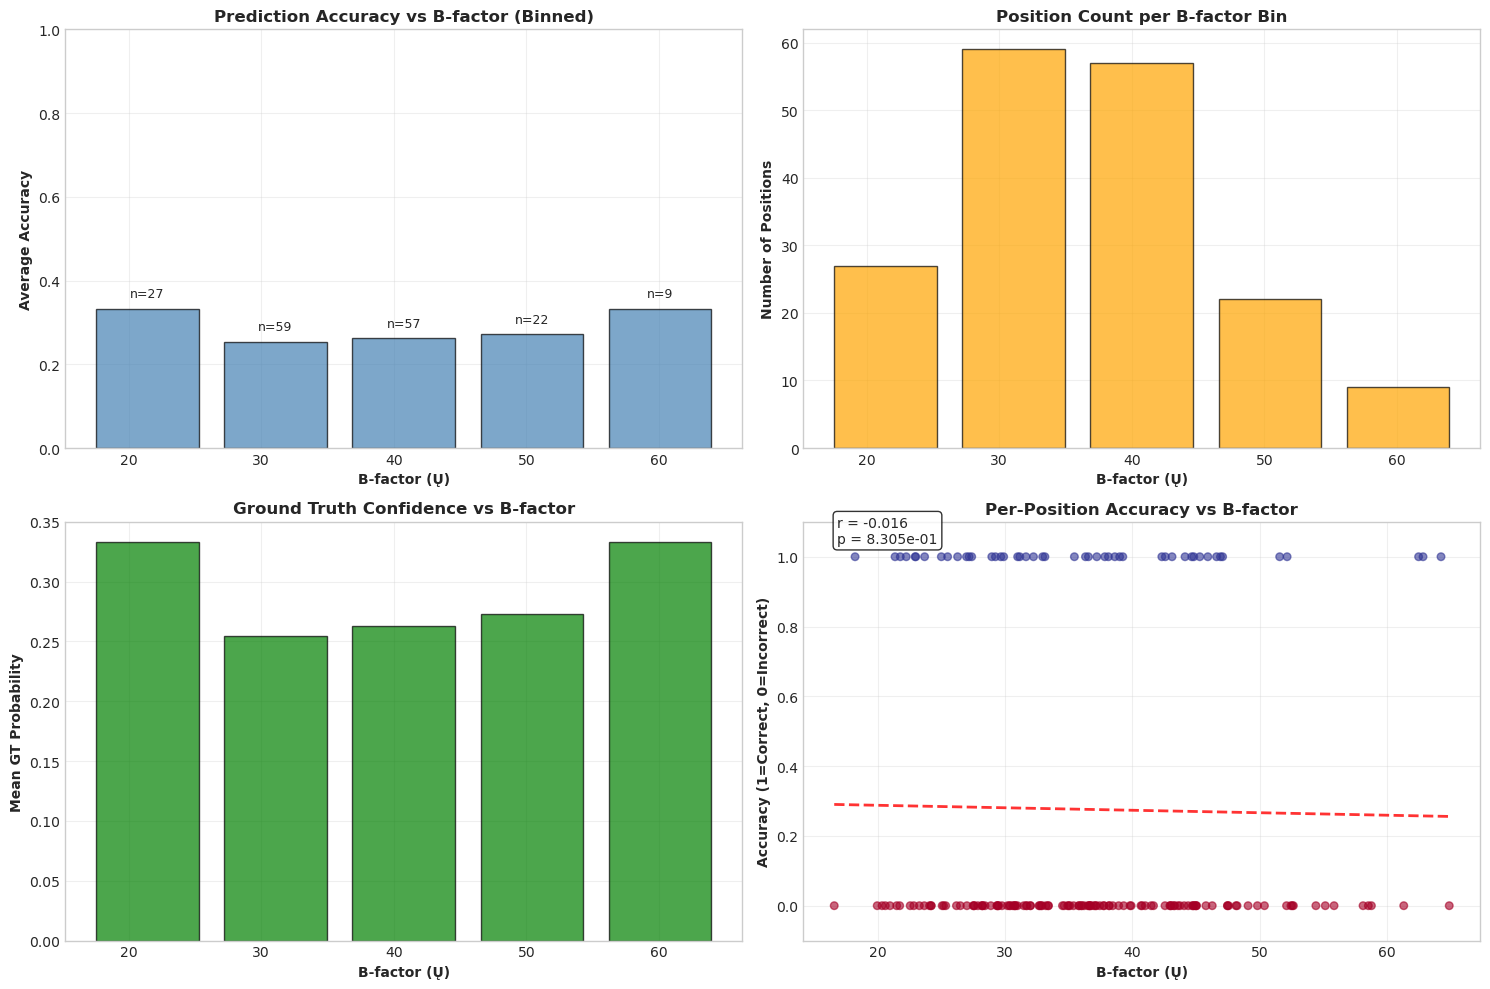


        ACCURACY vs B-FACTOR ANALYSIS

Overall correlation (individual positions):
  Pearson r = -0.016, p-value = 8.305e-01

B-factor bin analysis:
  Bin 21.4Ų: Accuracy=0.333, Count=27, GT_conf=0.333
  Bin 31.1Ų: Accuracy=0.254, Count=59, GT_conf=0.254
  Bin 40.7Ų: Accuracy=0.263, Count=57, GT_conf=0.263
  Bin 50.4Ų: Accuracy=0.273, Count=22, GT_conf=0.273
  Bin 60.1Ų: Accuracy=0.333, Count=9, GT_conf=0.333

Best performing B-factor range: 21.4Ų (accuracy=0.333)
Worst performing B-factor range: 31.1Ų (accuracy=0.254)
Accuracy difference: 0.079


In [19]:
# Accuracy vs B-factor analysis (binned)
def analyze_accuracy_vs_bfactor(predictions, ground_truth_indices, b_factors, n_bins=5):
    """
    Analyze prediction accuracy as a function of B-factor by binning positions
    """
    # Get predicted amino acids
    predicted_aa = np.argmax(predictions, axis=1)
    
    # Calculate per-position accuracy (binary: correct=1, incorrect=0)
    per_position_accuracy = (predicted_aa == ground_truth_indices).astype(float)
    
    # Create B-factor bins
    b_min, b_max = b_factors.min(), b_factors.max()
    bin_edges = np.linspace(b_min, b_max, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Assign each position to a bin
    bin_indices = np.digitize(b_factors, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Ensure within bounds
    
    # Calculate average accuracy and other metrics for each bin
    bin_accuracies = []
    bin_counts = []
    bin_confidence_gt = []
    bin_confidence_pred = []
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:  # If there are positions in this bin
            bin_accuracies.append(np.mean(per_position_accuracy[mask]))
            bin_counts.append(np.sum(mask))
            # Get confidence metrics for positions in this bin
            gt_probs = predictions[mask, ground_truth_indices[mask]]
            pred_conf = np.max(predictions[mask], axis=1)
            bin_confidence_gt.append(np.mean(gt_probs))
            bin_confidence_pred.append(np.mean(pred_conf))
        else:
            bin_accuracies.append(0)
            bin_counts.append(0)
            bin_confidence_gt.append(0)
            bin_confidence_pred.append(0)
    
    return {
        'bin_centers': bin_centers,
        'bin_edges': bin_edges,
        'bin_accuracies': np.array(bin_accuracies),
        'bin_counts': np.array(bin_counts),
        'bin_confidence_gt': np.array(bin_confidence_gt),
        'bin_confidence_pred': np.array(bin_confidence_pred),
        'per_position_accuracy': per_position_accuracy
    }

# Perform the analysis
bfactor_analysis = analyze_accuracy_vs_bfactor(final_predictions, ground_truth_indices, b_factors, n_bins=5)

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Accuracy vs B-factor (binned)
valid_bins = bfactor_analysis['bin_counts'] > 0
ax1.bar(bfactor_analysis['bin_centers'][valid_bins], 
        bfactor_analysis['bin_accuracies'][valid_bins], 
        width=(bfactor_analysis['bin_centers'][1] - bfactor_analysis['bin_centers'][0]) * 0.8,
        alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('B-factor (Ų)', fontweight='bold')
ax1.set_ylabel('Average Accuracy', fontweight='bold')
ax1.set_title('Prediction Accuracy vs B-factor (Binned)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Add count labels on bars
for i, (center, acc, count) in enumerate(zip(bfactor_analysis['bin_centers'][valid_bins], 
                                           bfactor_analysis['bin_accuracies'][valid_bins],
                                           bfactor_analysis['bin_counts'][valid_bins])):
    if count > 0:
        ax1.text(center, acc + 0.02, f'n={int(count)}', ha='center', va='bottom', fontsize=9)

# Plot 2: Number of positions per B-factor bin
ax2.bar(bfactor_analysis['bin_centers'][valid_bins], 
        bfactor_analysis['bin_counts'][valid_bins],
        width=(bfactor_analysis['bin_centers'][1] - bfactor_analysis['bin_centers'][0]) * 0.8,
        alpha=0.7, color='orange', edgecolor='black')
ax2.set_xlabel('B-factor (Ų)', fontweight='bold')
ax2.set_ylabel('Number of Positions', fontweight='bold')
ax2.set_title('Position Count per B-factor Bin', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: Ground truth confidence vs B-factor
ax3.bar(bfactor_analysis['bin_centers'][valid_bins], 
        bfactor_analysis['bin_confidence_gt'][valid_bins],
        width=(bfactor_analysis['bin_centers'][1] - bfactor_analysis['bin_centers'][0]) * 0.8,
        alpha=0.7, color='green', edgecolor='black')
ax3.set_xlabel('B-factor (Ų)', fontweight='bold')
ax3.set_ylabel('Mean GT Probability', fontweight='bold')
ax3.set_title('Ground Truth Confidence vs B-factor', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot - individual positions
colors = bfactor_analysis['per_position_accuracy']
scatter = ax4.scatter(b_factors, bfactor_analysis['per_position_accuracy'], 
                     c=colors, cmap='RdYlBu', alpha=0.6, s=30)
ax4.set_xlabel('B-factor (Ų)', fontweight='bold')
ax4.set_ylabel('Accuracy (1=Correct, 0=Incorrect)', fontweight='bold')
ax4.set_title('Per-Position Accuracy vs B-factor', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylim(-0.1, 1.1)

# Add trend line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(b_factors, bfactor_analysis['per_position_accuracy'])
line_x = np.linspace(b_factors.min(), b_factors.max(), 100)
line_y = slope * line_x + intercept
ax4.plot(line_x, line_y, 'r--', alpha=0.8, linewidth=2)
ax4.text(0.05, 0.95, f'r = {r_value:.3f}\np = {p_value:.3e}', 
         transform=ax4.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "=" * 50)
print("        ACCURACY vs B-FACTOR ANALYSIS")
print("=" * 50)

print(f"\nOverall correlation (individual positions):")
print(f"  Pearson r = {r_value:.3f}, p-value = {p_value:.3e}")

print(f"\nB-factor bin analysis:")
for i, (center, acc, count, gt_conf) in enumerate(zip(bfactor_analysis['bin_centers'][valid_bins],
                                                      bfactor_analysis['bin_accuracies'][valid_bins],
                                                      bfactor_analysis['bin_counts'][valid_bins],
                                                      bfactor_analysis['bin_confidence_gt'][valid_bins])):
    print(f"  Bin {center:.1f}Ų: Accuracy={acc:.3f}, Count={int(count)}, GT_conf={gt_conf:.3f}")

# Find best and worst performing B-factor ranges
if len(bfactor_analysis['bin_accuracies'][valid_bins]) > 0:
    best_bin_idx = np.argmax(bfactor_analysis['bin_accuracies'][valid_bins])
    worst_bin_idx = np.argmin(bfactor_analysis['bin_accuracies'][valid_bins])
    
    best_center = bfactor_analysis['bin_centers'][valid_bins][best_bin_idx]
    worst_center = bfactor_analysis['bin_centers'][valid_bins][worst_bin_idx]
    best_acc = bfactor_analysis['bin_accuracies'][valid_bins][best_bin_idx]
    worst_acc = bfactor_analysis['bin_accuracies'][valid_bins][worst_bin_idx]
    
    print(f"\nBest performing B-factor range: {best_center:.1f}Ų (accuracy={best_acc:.3f})")
    print(f"Worst performing B-factor range: {worst_center:.1f}Ų (accuracy={worst_acc:.3f})")
    print(f"Accuracy difference: {best_acc - worst_acc:.3f}")

/tmp/ipykernel_2188253/2418448134.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
/tmp/ipykernel_2188253/2418448134.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_2188253/2418448134.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


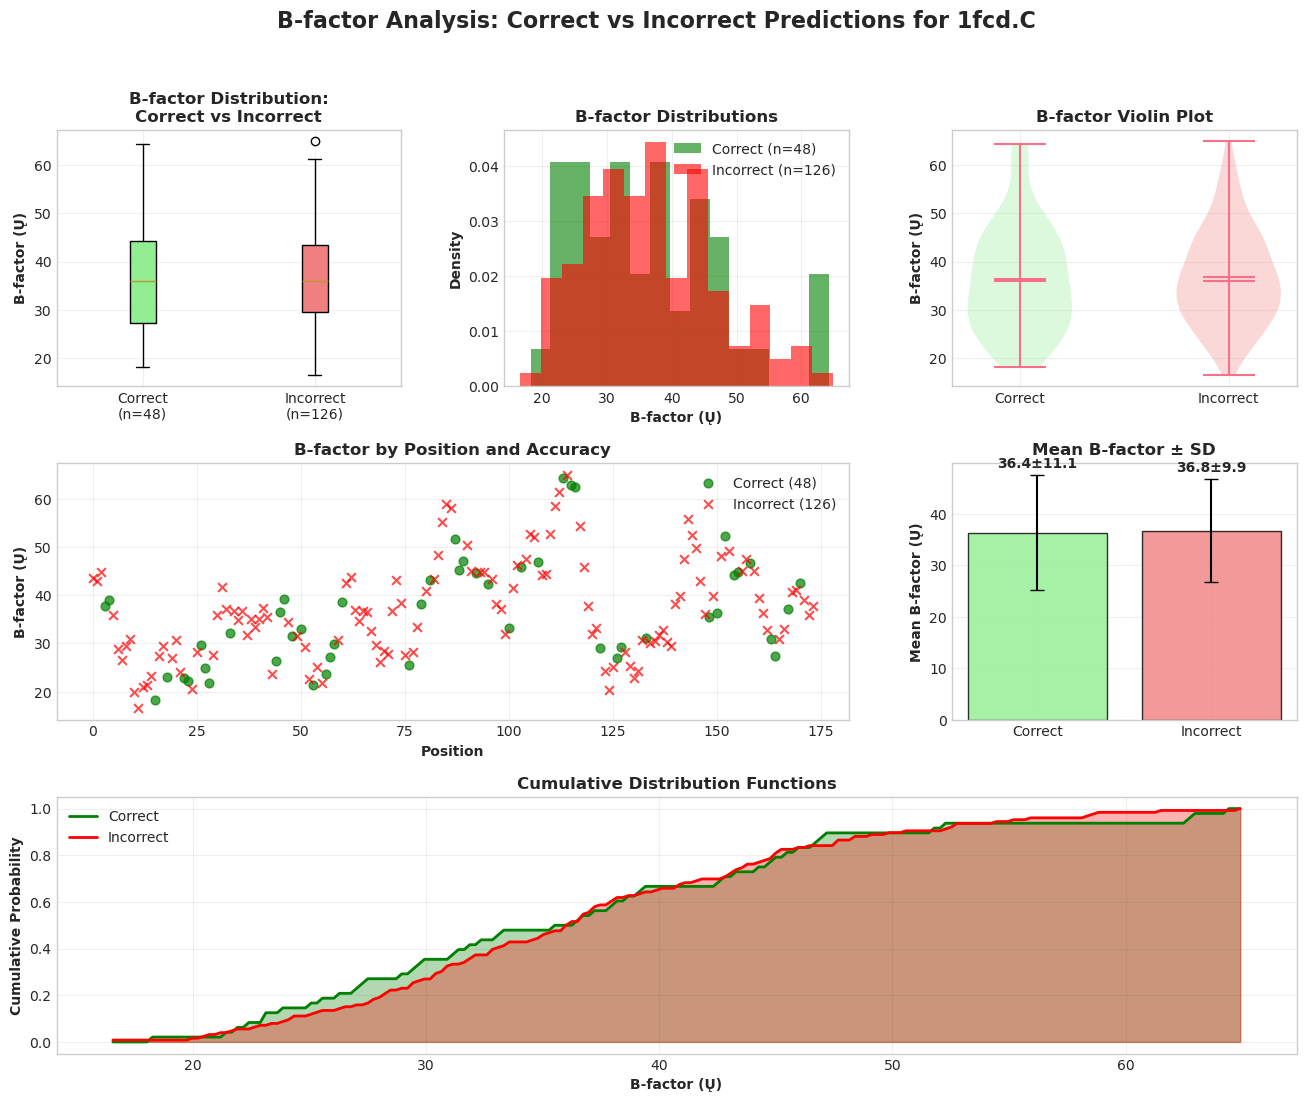


           B-FACTOR ANALYSIS: CORRECT vs INCORRECT PREDICTIONS

📊 BASIC STATISTICS:
   Correct predictions:    48 positions
   Incorrect predictions: 126 positions
   Overall accuracy:      27.6%

🎯 B-FACTOR STATISTICS:
   Mean B-factor (correct):    36.39 ± 11.08 Ų
   Mean B-factor (incorrect):  36.77 ± 9.94 Ų
   Difference in means:        -0.38 Ų
   Median B-factor (correct):  35.89 Ų
   Median B-factor (incorrect):36.01 Ų

🔬 STATISTICAL TESTS:
   T-test p-value:             0.8305
   Mann-Whitney U p-value:     0.6973
   Cohen's d (effect size):    -0.037
   Effect size interpretation: negligible
   Statistical significance:   NOT SIGNIFICANT (p ≥ 0.05)

💡 INTERPRETATION:
   B-factors are very similar between correct and incorrect predictions


In [20]:
# B-factor analysis: Correct vs Incorrect predictions
def analyze_correct_vs_incorrect_bfactors(predictions, ground_truth_indices, b_factors):
    """
    Compare B-factors for positions that were predicted correctly vs incorrectly
    """
    from scipy import stats
    
    # Get predicted amino acids
    predicted_aa = np.argmax(predictions, axis=1)
    
    # Create masks for correct and incorrect predictions
    correct_mask = predicted_aa == ground_truth_indices
    incorrect_mask = ~correct_mask
    
    # Get B-factors for correct and incorrect predictions
    b_factors_correct = b_factors[correct_mask]
    b_factors_incorrect = b_factors[incorrect_mask]
    
    # Calculate statistics
    results = {
        'n_correct': np.sum(correct_mask),
        'n_incorrect': np.sum(incorrect_mask),
        'mean_bfactor_correct': np.mean(b_factors_correct) if len(b_factors_correct) > 0 else 0,
        'mean_bfactor_incorrect': np.mean(b_factors_incorrect) if len(b_factors_incorrect) > 0 else 0,
        'std_bfactor_correct': np.std(b_factors_correct) if len(b_factors_correct) > 0 else 0,
        'std_bfactor_incorrect': np.std(b_factors_incorrect) if len(b_factors_incorrect) > 0 else 0,
        'median_bfactor_correct': np.median(b_factors_correct) if len(b_factors_correct) > 0 else 0,
        'median_bfactor_incorrect': np.median(b_factors_incorrect) if len(b_factors_incorrect) > 0 else 0,
        'b_factors_correct': b_factors_correct,
        'b_factors_incorrect': b_factors_incorrect,
        'correct_mask': correct_mask,
        'incorrect_mask': incorrect_mask
    }
    
    # Statistical tests
    if len(b_factors_correct) > 0 and len(b_factors_incorrect) > 0:
        # T-test for difference in means
        t_stat, t_pval = stats.ttest_ind(b_factors_correct, b_factors_incorrect)
        results['ttest_stat'] = t_stat
        results['ttest_pval'] = t_pval
        
        # Mann-Whitney U test (non-parametric)
        u_stat, u_pval = stats.mannwhitneyu(b_factors_correct, b_factors_incorrect, alternative='two-sided')
        results['mannwhitney_stat'] = u_stat
        results['mannwhitney_pval'] = u_pval
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(b_factors_correct) - 1) * np.var(b_factors_correct) + 
                             (len(b_factors_incorrect) - 1) * np.var(b_factors_incorrect)) / 
                            (len(b_factors_correct) + len(b_factors_incorrect) - 2))
        cohens_d = (np.mean(b_factors_correct) - np.mean(b_factors_incorrect)) / pooled_std if pooled_std > 0 else 0
        results['cohens_d'] = cohens_d
    
    return results

# Perform the analysis
bfactor_comparison = analyze_correct_vs_incorrect_bfactors(final_predictions, ground_truth_indices, b_factors)

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Box plot comparison
ax1 = fig.add_subplot(gs[0, 0])
box_data = [bfactor_comparison['b_factors_correct'], bfactor_comparison['b_factors_incorrect']]
box_labels = [f'Correct\n(n={bfactor_comparison["n_correct"]})', 
              f'Incorrect\n(n={bfactor_comparison["n_incorrect"]})']
bp = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax1.set_ylabel('B-factor (Ų)', fontweight='bold')
ax1.set_title('B-factor Distribution:\nCorrect vs Incorrect', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Histograms
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(bfactor_comparison['b_factors_correct'], bins=15, alpha=0.6, color='green', 
         label=f'Correct (n={bfactor_comparison["n_correct"]})', density=True)
ax2.hist(bfactor_comparison['b_factors_incorrect'], bins=15, alpha=0.6, color='red', 
         label=f'Incorrect (n={bfactor_comparison["n_incorrect"]})', density=True)
ax2.set_xlabel('B-factor (Ų)', fontweight='bold')
ax2.set_ylabel('Density', fontweight='bold')
ax2.set_title('B-factor Distributions', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Violin plot
ax3 = fig.add_subplot(gs[0, 2])
parts = ax3.violinplot([bfactor_comparison['b_factors_correct'], bfactor_comparison['b_factors_incorrect']], 
                       positions=[1, 2], showmeans=True, showmedians=True)
parts['bodies'][0].set_facecolor('lightgreen')
parts['bodies'][1].set_facecolor('lightcoral')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Correct', 'Incorrect'])
ax3.set_ylabel('B-factor (Ų)', fontweight='bold')
ax3.set_title('B-factor Violin Plot', fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Scatter plot with accuracy overlay
ax4 = fig.add_subplot(gs[1, :2])
correct_positions = np.where(bfactor_comparison['correct_mask'])[0]
incorrect_positions = np.where(bfactor_comparison['incorrect_mask'])[0]

ax4.scatter(correct_positions, b_factors[correct_positions], c='green', alpha=0.7, s=40, 
           label=f'Correct ({len(correct_positions)})', marker='o')
ax4.scatter(incorrect_positions, b_factors[incorrect_positions], c='red', alpha=0.7, s=40, 
           label=f'Incorrect ({len(incorrect_positions)})', marker='x')
ax4.set_xlabel('Position', fontweight='bold')
ax4.set_ylabel('B-factor (Ų)', fontweight='bold')
ax4.set_title('B-factor by Position and Accuracy', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Mean B-factor comparison bar chart
ax5 = fig.add_subplot(gs[1, 2])
means = [bfactor_comparison['mean_bfactor_correct'], bfactor_comparison['mean_bfactor_incorrect']]
stds = [bfactor_comparison['std_bfactor_correct'], bfactor_comparison['std_bfactor_incorrect']]
bars = ax5.bar(['Correct', 'Incorrect'], means, yerr=stds, capsize=5, 
               color=['lightgreen', 'lightcoral'], edgecolor='black', alpha=0.8)
ax5.set_ylabel('Mean B-factor (Ų)', fontweight='bold')
ax5.set_title('Mean B-factor ± SD', fontweight='bold')
ax5.grid(True, alpha=0.3)

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + std + 1,
             f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 6: Cumulative distribution
ax6 = fig.add_subplot(gs[2, :])
from scipy.stats import ecdf
ecdf_correct = ecdf(bfactor_comparison['b_factors_correct'])
ecdf_incorrect = ecdf(bfactor_comparison['b_factors_incorrect'])

x_range = np.linspace(min(b_factors), max(b_factors), 200)
ax6.plot(x_range, ecdf_correct.cdf.evaluate(x_range), 'g-', linewidth=2, label='Correct')
ax6.plot(x_range, ecdf_incorrect.cdf.evaluate(x_range), 'r-', linewidth=2, label='Incorrect')
ax6.fill_between(x_range, ecdf_correct.cdf.evaluate(x_range), alpha=0.3, color='green')
ax6.fill_between(x_range, ecdf_incorrect.cdf.evaluate(x_range), alpha=0.3, color='red')
ax6.set_xlabel('B-factor (Ų)', fontweight='bold')
ax6.set_ylabel('Cumulative Probability', fontweight='bold')
ax6.set_title('Cumulative Distribution Functions', fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.suptitle(f'B-factor Analysis: Correct vs Incorrect Predictions for {protein_id}', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "=" * 70)
print("           B-FACTOR ANALYSIS: CORRECT vs INCORRECT PREDICTIONS")
print("=" * 70)

print(f"\n📊 BASIC STATISTICS:")
print(f"   Correct predictions:   {bfactor_comparison['n_correct']:3d} positions")
print(f"   Incorrect predictions: {bfactor_comparison['n_incorrect']:3d} positions")
print(f"   Overall accuracy:      {bfactor_comparison['n_correct']/(bfactor_comparison['n_correct']+bfactor_comparison['n_incorrect'])*100:.1f}%")

print(f"\n🎯 B-FACTOR STATISTICS:")
print(f"   Mean B-factor (correct):    {bfactor_comparison['mean_bfactor_correct']:.2f} ± {bfactor_comparison['std_bfactor_correct']:.2f} Ų")
print(f"   Mean B-factor (incorrect):  {bfactor_comparison['mean_bfactor_incorrect']:.2f} ± {bfactor_comparison['std_bfactor_incorrect']:.2f} Ų")
print(f"   Difference in means:        {bfactor_comparison['mean_bfactor_correct'] - bfactor_comparison['mean_bfactor_incorrect']:.2f} Ų")
print(f"   Median B-factor (correct):  {bfactor_comparison['median_bfactor_correct']:.2f} Ų")
print(f"   Median B-factor (incorrect):{bfactor_comparison['median_bfactor_incorrect']:.2f} Ų")

if 'ttest_pval' in bfactor_comparison:
    print(f"\n🔬 STATISTICAL TESTS:")
    print(f"   T-test p-value:             {bfactor_comparison['ttest_pval']:.4f}")
    print(f"   Mann-Whitney U p-value:     {bfactor_comparison['mannwhitney_pval']:.4f}")
    print(f"   Cohen's d (effect size):    {bfactor_comparison['cohens_d']:.3f}")
    
    # Interpret effect size
    if abs(bfactor_comparison['cohens_d']) < 0.2:
        effect_size = "negligible"
    elif abs(bfactor_comparison['cohens_d']) < 0.5:
        effect_size = "small"
    elif abs(bfactor_comparison['cohens_d']) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"   Effect size interpretation: {effect_size}")
    
    # Statistical significance
    alpha = 0.05
    if bfactor_comparison['ttest_pval'] < alpha:
        significance = f"SIGNIFICANT (p < {alpha})"
    else:
        significance = f"NOT SIGNIFICANT (p ≥ {alpha})"
    
    print(f"   Statistical significance:   {significance}")

print(f"\n💡 INTERPRETATION:")
mean_diff = bfactor_comparison['mean_bfactor_correct'] - bfactor_comparison['mean_bfactor_incorrect']
if abs(mean_diff) < 1.0:
    interpretation = "B-factors are very similar between correct and incorrect predictions"
elif mean_diff > 0:
    interpretation = f"Correct predictions tend to have higher B-factors (+{mean_diff:.1f} Ų)"
else:
    interpretation = f"Incorrect predictions tend to have higher B-factors (+{abs(mean_diff):.1f} Ų)"

print(f"   {interpretation}")
print("=" * 70)

/tmp/ipykernel_2188253/2609990338.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


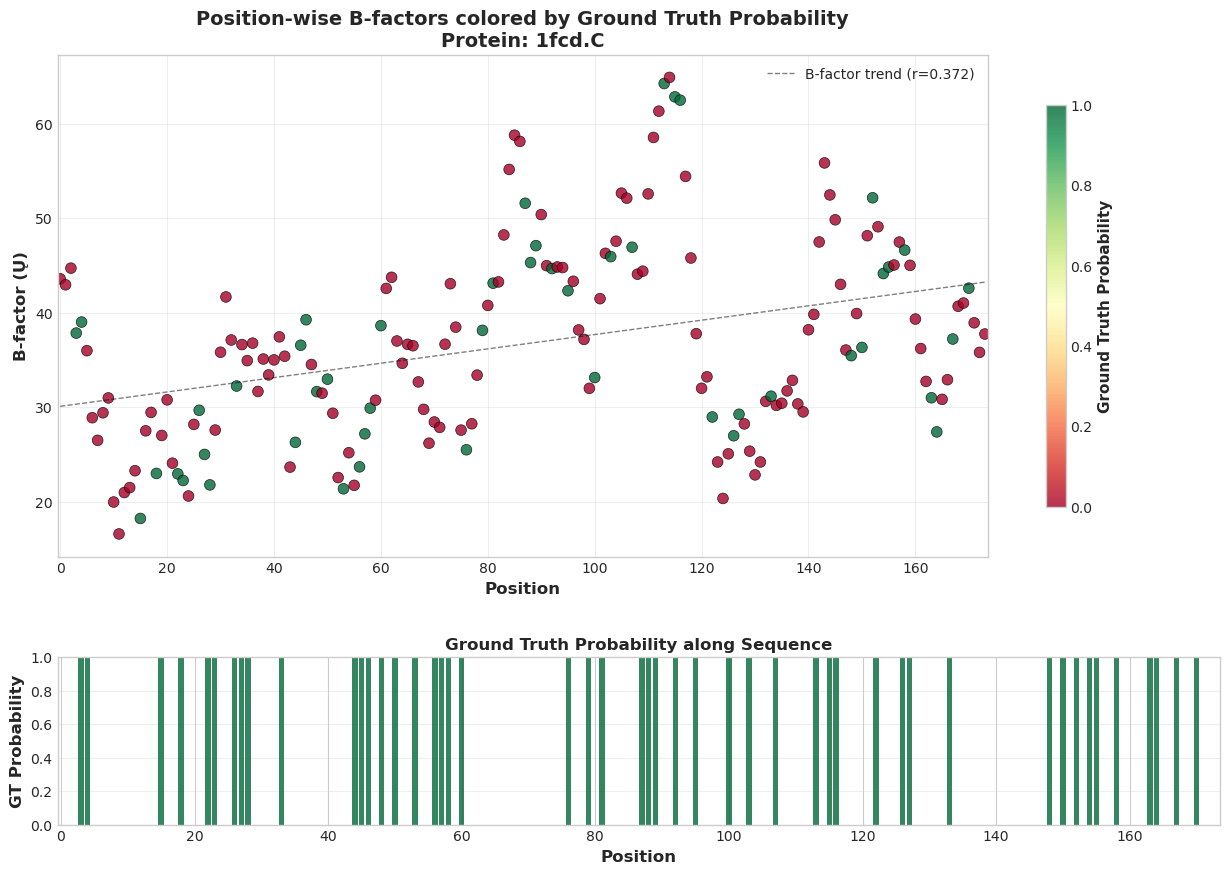


    POSITION-WISE B-FACTOR vs GROUND TRUTH PROBABILITY

📊 CORRELATION ANALYSIS:
   Pearson correlation:  r = -0.016, p = 8.305e-01
   Spearman correlation: ρ = -0.030, p = 6.973e-01

🎯 B-FACTORS BY GROUND TRUTH PROBABILITY BINS:
   GT Prob 0.1: n=126, B-factor=36.8±9.9 Ų, median=36.0 Ų
   GT Prob 0.9: n=48, B-factor=36.4±11.1 Ų, median=35.9 Ų

📍 EXTREME POSITIONS:
   High confidence (>0.8): 48 positions
      Mean B-factor: 36.4 Ų
   Low confidence (<0.2):  126 positions
      Mean B-factor: 36.8 Ų
   Zero confidence (=0.0): 126 positions
      Mean B-factor: 36.8 Ų

🔍 SPECIFIC EXAMPLES:
   Top 5 highest GT probability positions:
      Pos 170: GT_prob=1.000, B-factor=42.6, True=A, Pred=A
      Pos 167: GT_prob=1.000, B-factor=37.2, True=A, Pred=A
      Pos 164: GT_prob=1.000, B-factor=27.4, True=A, Pred=A
      Pos 163: GT_prob=1.000, B-factor=31.0, True=N, Pred=N
      Pos 152: GT_prob=1.000, B-factor=52.2, True=D, Pred=D


In [21]:
# Position-wise B-factor scatter plot colored by ground truth probability
def create_bfactor_gt_probability_scatter(b_factors, ground_truth_probs, protein_id):
    """
    Create a scatter plot of B-factors vs position, colored by ground truth probability
    """
    positions = np.arange(len(b_factors))
    
    # Create the figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), 
                                   gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.3})
    
    # Main scatter plot
    scatter = ax1.scatter(positions, b_factors, c=ground_truth_probs, 
                         cmap='RdYlGn', s=60, alpha=0.8, edgecolors='black', linewidth=0.5)
    
    ax1.set_xlabel('Position', fontsize=12, fontweight='bold')
    ax1.set_ylabel('B-factor (Ų)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Position-wise B-factors colored by Ground Truth Probability\nProtein: {protein_id}', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar.set_label('Ground Truth Probability', fontsize=11, fontweight='bold')
    
    # Add trend line for B-factors
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(positions, b_factors)
    line_x = np.array([positions.min(), positions.max()])
    line_y = slope * line_x + intercept
    ax1.plot(line_x, line_y, 'k--', alpha=0.5, linewidth=1, 
             label=f'B-factor trend (r={r_value:.3f})')
    ax1.legend()
    
    # Bottom plot: Ground truth probability along sequence
    colors = plt.cm.RdYlGn(ground_truth_probs)
    bars = ax2.bar(positions, ground_truth_probs, color=colors, alpha=0.8, width=0.8)
    ax2.set_xlabel('Position', fontsize=12, fontweight='bold')
    ax2.set_ylabel('GT Probability', fontsize=12, fontweight='bold')
    ax2.set_title('Ground Truth Probability along Sequence', fontsize=12, fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Align x-axes
    ax1.set_xlim(-0.5, len(positions) - 0.5)
    ax2.set_xlim(-0.5, len(positions) - 0.5)
    
    plt.tight_layout()
    return fig, (ax1, ax2)

# Create the visualization
fig, (ax1, ax2) = create_bfactor_gt_probability_scatter(b_factors, analysis['ground_truth_probs'], protein_id)
plt.show()

# Additional analysis: Correlation between B-factor and GT probability position-by-position
print("\n" + "=" * 60)
print("    POSITION-WISE B-FACTOR vs GROUND TRUTH PROBABILITY")
print("=" * 60)

from scipy.stats import pearsonr, spearmanr

# Overall correlation
pearson_r, pearson_p = pearsonr(b_factors, analysis['ground_truth_probs'])
spearman_r, spearman_p = spearmanr(b_factors, analysis['ground_truth_probs'])

print(f"\n📊 CORRELATION ANALYSIS:")
print(f"   Pearson correlation:  r = {pearson_r:.3f}, p = {pearson_p:.3e}")
print(f"   Spearman correlation: ρ = {spearman_r:.3f}, p = {spearman_p:.3e}")

# Binned analysis by GT probability
def analyze_by_gt_probability_bins(b_factors, gt_probs, n_bins=5):
    """Analyze B-factors binned by ground truth probability"""
    
    # Create bins based on GT probability
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_indices = np.digitize(gt_probs, bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_stats = []
    for i in range(n_bins):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            stats = {
                'bin_center': bin_centers[i],
                'count': np.sum(mask),
                'mean_bfactor': np.mean(b_factors[mask]),
                'std_bfactor': np.std(b_factors[mask]),
                'median_bfactor': np.median(b_factors[mask])
            }
        else:
            stats = {
                'bin_center': bin_centers[i],
                'count': 0,
                'mean_bfactor': 0,
                'std_bfactor': 0,
                'median_bfactor': 0
            }
        bin_stats.append(stats)
    
    return bin_stats

# Perform binned analysis
gt_prob_bins = analyze_by_gt_probability_bins(b_factors, analysis['ground_truth_probs'], n_bins=5)

print(f"\n🎯 B-FACTORS BY GROUND TRUTH PROBABILITY BINS:")
for i, stats in enumerate(gt_prob_bins):
    if stats['count'] > 0:
        print(f"   GT Prob {stats['bin_center']:.1f}: n={stats['count']:2d}, "
              f"B-factor={stats['mean_bfactor']:.1f}±{stats['std_bfactor']:.1f} Ų, "
              f"median={stats['median_bfactor']:.1f} Ų")

# Find positions with extreme values
high_confidence_positions = np.where(analysis['ground_truth_probs'] > 0.8)[0]
low_confidence_positions = np.where(analysis['ground_truth_probs'] < 0.2)[0]
zero_confidence_positions = np.where(analysis['ground_truth_probs'] == 0.0)[0]

print(f"\n📍 EXTREME POSITIONS:")
print(f"   High confidence (>0.8): {len(high_confidence_positions)} positions")
if len(high_confidence_positions) > 0:
    print(f"      Mean B-factor: {np.mean(b_factors[high_confidence_positions]):.1f} Ų")
    
print(f"   Low confidence (<0.2):  {len(low_confidence_positions)} positions")
if len(low_confidence_positions) > 0:
    print(f"      Mean B-factor: {np.mean(b_factors[low_confidence_positions]):.1f} Ų")
    
print(f"   Zero confidence (=0.0): {len(zero_confidence_positions)} positions")
if len(zero_confidence_positions) > 0:
    print(f"      Mean B-factor: {np.mean(b_factors[zero_confidence_positions]):.1f} Ų")

# Show some specific examples
print(f"\n🔍 SPECIFIC EXAMPLES:")
# Highest GT probability positions
highest_gt_indices = np.argsort(analysis['ground_truth_probs'])[-5:][::-1]
print(f"   Top 5 highest GT probability positions:")
for idx in highest_gt_indices:
    aa_true = idx_to_aa[ground_truth_indices[idx]]
    aa_pred = idx_to_aa[analysis['predicted_aa'][idx]]
    print(f"      Pos {idx}: GT_prob={analysis['ground_truth_probs'][idx]:.3f}, "
          f"B-factor={b_factors[idx]:.1f}, True={aa_true}, Pred={aa_pred}")

print("=" * 60)

In [22]:
# DSSP Secondary Structure Analysis
print("=" * 70)
print("                    DSSP SECONDARY STRUCTURE ANALYSIS")
print("=" * 70)

# Load DSSP data from the same pickle file
if protein_id in b_factor_data:
    if 'dssp' in b_factor_data[protein_id]:
        dssp_sequence = b_factor_data[protein_id]['dssp']
        print(f"✅ DSSP data found for {protein_id}")
        print(f"   DSSP sequence length: {len(dssp_sequence)}")
        print(f"   Sample DSSP: {dssp_sequence[:20]}...")
    else:
        print(f"❌ DSSP field not found for {protein_id}")
        print(f"   Available fields: {list(b_factor_data[protein_id].keys())}")
        dssp_sequence = None
else:
    print(f"❌ Protein {protein_id} not found in data")
    dssp_sequence = None

# If DSSP data is available, proceed with analysis
if dssp_sequence is not None:
    # Ensure lengths match
    dssp_sequence = dssp_sequence[:len(ground_truth_indices)]
    
    # DSSP character mapping and analysis
    dssp_chars = list(set(dssp_sequence))
    dssp_counts = {char: dssp_sequence.count(char) for char in dssp_chars}
    
    print(f"\n📊 DSSP CHARACTER DISTRIBUTION:")
    for char, count in sorted(dssp_counts.items()):
        percentage = (count / len(dssp_sequence)) * 100
        print(f"   '{char}': {count:3d} positions ({percentage:5.1f}%)")
    
    # Standard DSSP to simplified secondary structure mapping
    dssp_to_ss = {
        'H': 'Helix',      # Alpha helix
        'G': 'Helix',      # 3-10 helix  
        'I': 'Helix',      # Pi helix
        'B': 'Sheet',      # Beta bridge
        'E': 'Sheet',      # Extended strand (beta sheet)
        'T': 'Turn',       # Turn
        'S': 'Turn',       # Bend
        ' ': 'Coil',       # Coil/Loop (space character)
        '-': 'Coil',       # Coil/Loop (dash character)
        'C': 'Coil',       # Coil (sometimes used)
    }
    
    # Map DSSP to simplified secondary structure
    ss_simplified = []
    for char in dssp_sequence:
        ss_simplified.append(dssp_to_ss.get(char, 'Other'))
    
    ss_simplified = np.array(ss_simplified)
    ss_types = ['Helix', 'Sheet', 'Turn', 'Coil', 'Other']
    ss_counts = {ss_type: np.sum(ss_simplified == ss_type) for ss_type in ss_types}
    
    print(f"\n🧬 SIMPLIFIED SECONDARY STRUCTURE:")
    for ss_type, count in ss_counts.items():
        if count > 0:
            percentage = (count / len(ss_simplified)) * 100
            print(f"   {ss_type}: {count:3d} positions ({percentage:5.1f}%)")

else:
    print("❌ Cannot proceed with DSSP analysis - data not available")
    # Create dummy data for demonstration
    ss_types = ['Helix', 'Sheet', 'Turn', 'Coil']
    ss_simplified = np.random.choice(ss_types, size=len(ground_truth_indices))
    dssp_sequence = ''.join(np.random.choice(['H', 'E', 'T', ' '], size=len(ground_truth_indices)))
    print("⚠️  Using randomly generated secondary structure data for demonstration")

                    DSSP SECONDARY STRUCTURE ANALYSIS
✅ DSSP data found for 1fcd.C
   DSSP sequence length: 174
   Sample DSSP: ['-', '-', '-', 'H', 'H', 'H', 'H', 'H', 'H', 'T', 'T', 'T', 'T', 'T', 'S', '-', 'G', 'G', 'G', '-']...

📊 DSSP CHARACTER DISTRIBUTION:
   '-':  38 positions ( 21.8%)
   'G':   6 positions (  3.4%)
   'H':  80 positions ( 46.0%)
   'I':  10 positions (  5.7%)
   'P':   4 positions (  2.3%)
   'S':  19 positions ( 10.9%)
   'T':  17 positions (  9.8%)

🧬 SIMPLIFIED SECONDARY STRUCTURE:
   Helix:  96 positions ( 55.2%)
   Turn:  36 positions ( 20.7%)
   Coil:  38 positions ( 21.8%)
   Other:   4 positions (  2.3%)


In [23]:
# Analyze prediction accuracy by secondary structure
def analyze_accuracy_by_secondary_structure(predictions, ground_truth_indices, ss_simplified, ss_types):
    """Analyze prediction accuracy for different secondary structure types"""
    
    predicted_aa = np.argmax(predictions, axis=1)
    per_position_accuracy = (predicted_aa == ground_truth_indices).astype(float)
    ground_truth_probs = predictions[np.arange(len(ground_truth_indices)), ground_truth_indices]
    
    ss_analysis = {}
    
    for ss_type in ss_types:
        mask = ss_simplified == ss_type
        n_positions = np.sum(mask)
        
        if n_positions > 0:
            accuracy = np.mean(per_position_accuracy[mask])
            mean_gt_prob = np.mean(ground_truth_probs[mask])
            std_gt_prob = np.std(ground_truth_probs[mask])
            
            ss_analysis[ss_type] = {
                'n_positions': n_positions,
                'accuracy': accuracy,
                'mean_gt_prob': mean_gt_prob,
                'std_gt_prob': std_gt_prob,
                'positions': np.where(mask)[0],
                'accuracies': per_position_accuracy[mask],
                'gt_probs': ground_truth_probs[mask]
            }
        else:
            ss_analysis[ss_type] = {
                'n_positions': 0,
                'accuracy': 0,
                'mean_gt_prob': 0,
                'std_gt_prob': 0,
                'positions': np.array([]),
                'accuracies': np.array([]),
                'gt_probs': np.array([])
            }
    
    return ss_analysis

# Perform secondary structure analysis
ss_analysis = analyze_accuracy_by_secondary_structure(
    final_predictions, ground_truth_indices, ss_simplified, ss_types
)

print(f"\n" + "=" * 70)
print("        PREDICTION ACCURACY BY SECONDARY STRUCTURE TYPE")
print("=" * 70)

# Statistical comparison between secondary structure types
from scipy.stats import chi2_contingency, kruskal

# Create contingency table for chi-square test
correct_by_ss = []
incorrect_by_ss = []
ss_labels = []

for ss_type in ss_types:
    if ss_analysis[ss_type]['n_positions'] > 0:
        n_correct = int(ss_analysis[ss_type]['accuracy'] * ss_analysis[ss_type]['n_positions'])
        n_incorrect = ss_analysis[ss_type]['n_positions'] - n_correct
        correct_by_ss.append(n_correct)
        incorrect_by_ss.append(n_incorrect)
        ss_labels.append(ss_type)
        
        print(f"\n🧬 {ss_type.upper()}:")
        print(f"   Positions: {ss_analysis[ss_type]['n_positions']:3d}")
        print(f"   Accuracy:  {ss_analysis[ss_type]['accuracy']:.3f} ({ss_analysis[ss_type]['accuracy']*100:.1f}%)")
        print(f"   Correct:   {n_correct:3d} positions")
        print(f"   Incorrect: {n_incorrect:3d} positions") 
        print(f"   Mean GT Probability: {ss_analysis[ss_type]['mean_gt_prob']:.3f} ± {ss_analysis[ss_type]['std_gt_prob']:.3f}")

# Perform chi-square test if we have data
if len(correct_by_ss) > 1:
    contingency_table = np.array([correct_by_ss, incorrect_by_ss])
    chi2_stat, chi2_pval, dof, expected = chi2_contingency(contingency_table)
    
    print(f"\n📊 STATISTICAL TESTS:")
    print(f"   Chi-square test: χ² = {chi2_stat:.3f}, p = {chi2_pval:.4f}")
    
    if chi2_pval < 0.05:
        print(f"   ✅ SIGNIFICANT difference in accuracy between secondary structures")
    else:
        print(f"   ❌ NO significant difference in accuracy between secondary structures")

print("=" * 70)


        PREDICTION ACCURACY BY SECONDARY STRUCTURE TYPE

🧬 HELIX:
   Positions:  96
   Accuracy:  0.292 (29.2%)
   Correct:    28 positions
   Incorrect:  68 positions
   Mean GT Probability: 0.292 ± 0.455

🧬 TURN:
   Positions:  36
   Accuracy:  0.306 (30.6%)
   Correct:    11 positions
   Incorrect:  25 positions
   Mean GT Probability: 0.306 ± 0.461

🧬 COIL:
   Positions:  38
   Accuracy:  0.158 (15.8%)
   Correct:     6 positions
   Incorrect:  32 positions
   Mean GT Probability: 0.158 ± 0.365

🧬 OTHER:
   Positions:   4
   Accuracy:  0.750 (75.0%)
   Correct:     3 positions
   Incorrect:   1 positions
   Mean GT Probability: 0.750 ± 0.433

📊 STATISTICAL TESTS:
   Chi-square test: χ² = 7.428, p = 0.0594
   ❌ NO significant difference in accuracy between secondary structures


/tmp/ipykernel_2188253/1928499607.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(gt_probs_by_ss, labels=valid_ss_types, patch_artist=True)


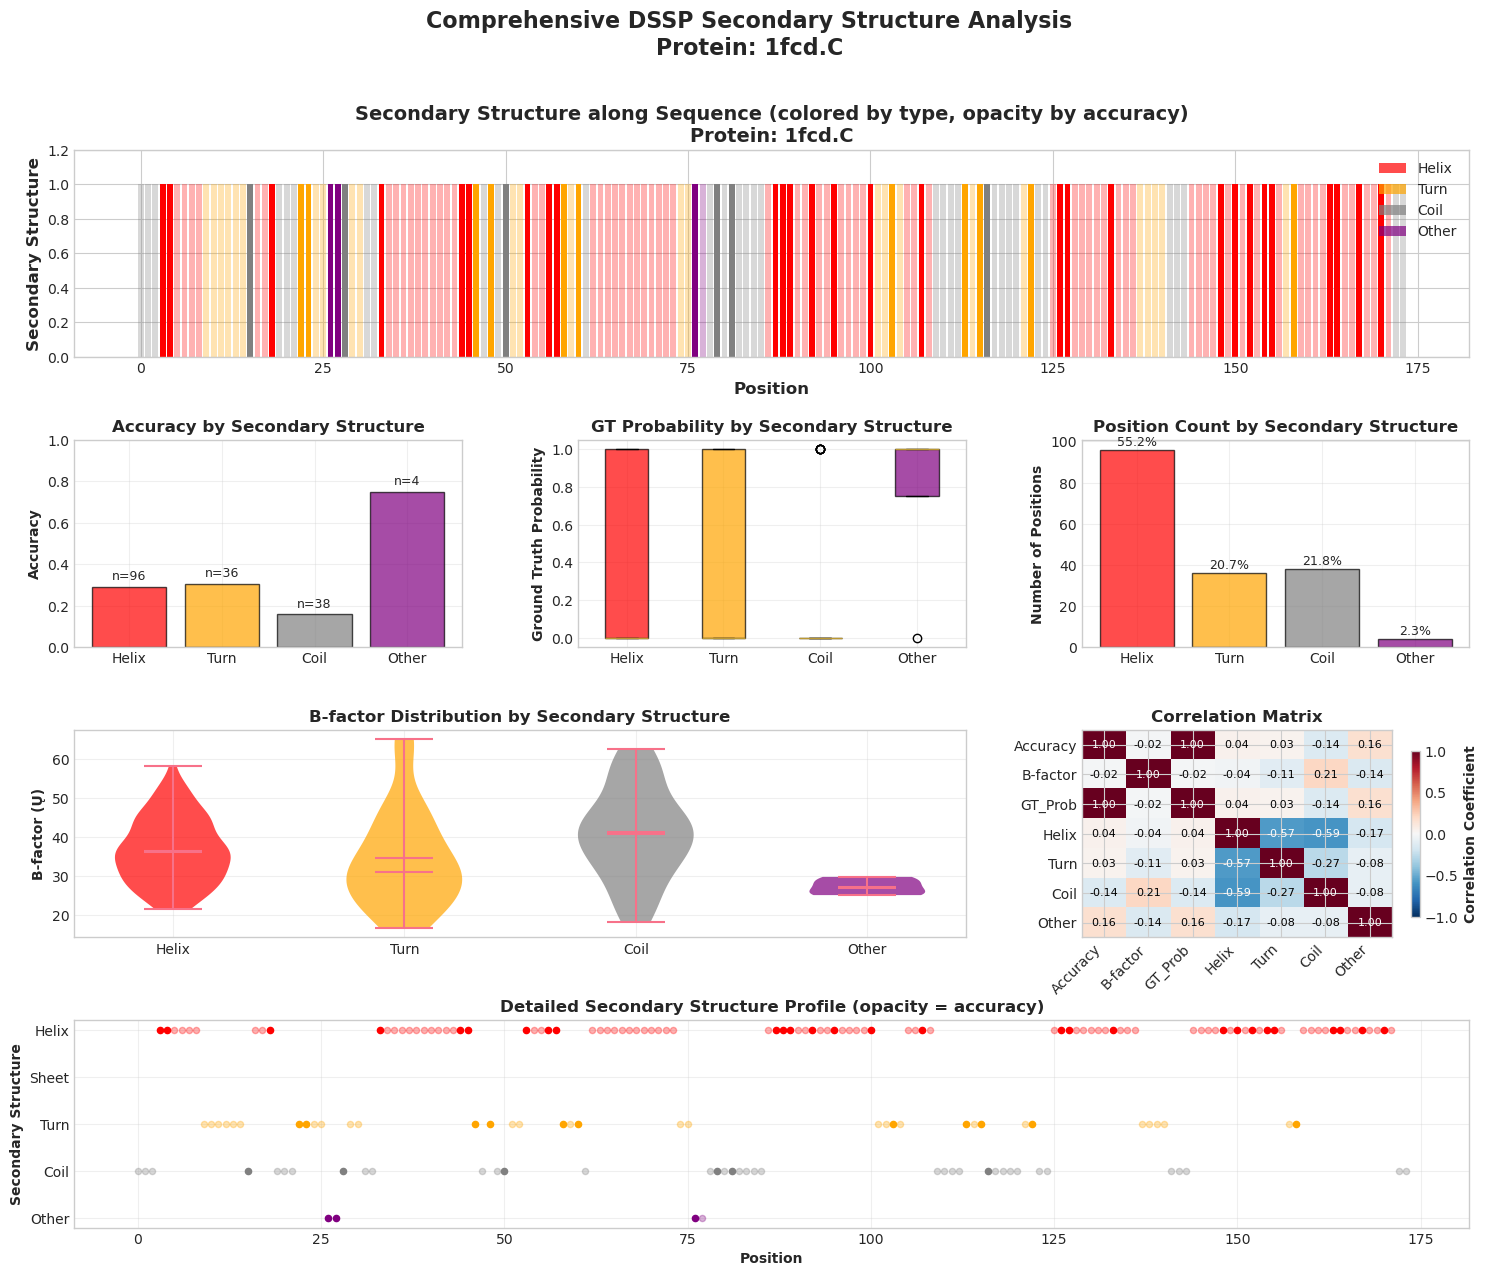


                    DETAILED DSSP ANALYSIS SUMMARY

🏆 BEST PERFORMING SECONDARY STRUCTURE:
   Other: 0.750 accuracy (4 positions)

🔻 WORST PERFORMING SECONDARY STRUCTURE:
   Coil: 0.158 accuracy (38 positions)

📈 ACCURACY RANGE:
   Difference: 0.592


In [24]:
# Create comprehensive DSSP visualization
def create_dssp_analysis_plot(ss_simplified, ss_analysis, b_factors, ground_truth_probs, protein_id):
    """Create comprehensive visualization of DSSP secondary structure analysis"""
    
    # Color mapping for secondary structures
    ss_colors = {
        'Helix': 'red',
        'Sheet': 'blue', 
        'Turn': 'orange',
        'Coil': 'gray',
        'Other': 'purple'
    }
    
    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)
    
    positions = np.arange(len(ss_simplified))
    
    # Plot 1: Secondary structure along sequence with accuracy
    ax1 = fig.add_subplot(gs[0, :])
    
    # Create color array for positions
    position_colors = []
    for ss in ss_simplified:
        position_colors.append(ss_colors.get(ss, 'black'))
    
    # Plot secondary structure bars colored by accuracy
    for pos, (ss, gt_prob) in enumerate(zip(ss_simplified, ground_truth_probs)):
        color = ss_colors.get(ss, 'black')
        alpha = 0.3 + 0.7 * gt_prob  # Higher accuracy = more opaque
        ax1.bar(pos, 1, color=color, alpha=alpha, width=0.8)
    
    ax1.set_xlabel('Position', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Secondary Structure', fontweight='bold', fontsize=12)
    ax1.set_title(f'Secondary Structure along Sequence (colored by type, opacity by accuracy)\nProtein: {protein_id}', 
                  fontweight='bold', fontsize=14)
    ax1.set_ylim(0, 1.2)
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.7, label=ss_type) 
                      for ss_type, color in ss_colors.items() 
                      if any(ss_simplified == ss_type)]
    ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    # Plot 2: Accuracy by secondary structure type (bar plot)
    ax2 = fig.add_subplot(gs[1, 0])
    valid_ss_types = [ss for ss in ss_types if ss_analysis[ss]['n_positions'] > 0]
    accuracies = [ss_analysis[ss]['accuracy'] for ss in valid_ss_types]
    counts = [ss_analysis[ss]['n_positions'] for ss in valid_ss_types]
    colors_bar = [ss_colors[ss] for ss in valid_ss_types]
    
    bars = ax2.bar(valid_ss_types, accuracies, color=colors_bar, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Accuracy', fontweight='bold')
    ax2.set_title('Accuracy by Secondary Structure', fontweight='bold')
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'n={count}', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Ground truth probability by secondary structure
    ax3 = fig.add_subplot(gs[1, 1])
    gt_probs_by_ss = [ss_analysis[ss]['gt_probs'] for ss in valid_ss_types if len(ss_analysis[ss]['gt_probs']) > 0]
    bp = ax3.boxplot(gt_probs_by_ss, labels=valid_ss_types, patch_artist=True)
    
    for patch, ss_type in zip(bp['boxes'], valid_ss_types):
        patch.set_facecolor(ss_colors[ss_type])
        patch.set_alpha(0.7)
    
    ax3.set_ylabel('Ground Truth Probability', fontweight='bold')
    ax3.set_title('GT Probability by Secondary Structure', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Position count by secondary structure
    ax4 = fig.add_subplot(gs[1, 2])
    bars_count = ax4.bar(valid_ss_types, counts, color=colors_bar, alpha=0.7, edgecolor='black')
    ax4.set_ylabel('Number of Positions', fontweight='bold')
    ax4.set_title('Position Count by Secondary Structure', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Add percentage labels
    total_positions = sum(counts)
    for bar, count in zip(bars_count, counts):
        height = bar.get_height()
        percentage = (count / total_positions) * 100
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Plot 5: B-factor vs Secondary Structure
    ax5 = fig.add_subplot(gs[2, :2])
    b_factors_by_ss = []
    ss_labels_for_violin = []
    
    for ss_type in valid_ss_types:
        positions = ss_analysis[ss_type]['positions']
        if len(positions) > 0:
            b_factors_by_ss.append(b_factors[positions])
            ss_labels_for_violin.append(ss_type)
    
    parts = ax5.violinplot(b_factors_by_ss, positions=range(len(ss_labels_for_violin)), 
                          showmeans=True, showmedians=True)
    
    for i, (patch, ss_type) in enumerate(zip(parts['bodies'], ss_labels_for_violin)):
        patch.set_facecolor(ss_colors[ss_type])
        patch.set_alpha(0.7)
    
    ax5.set_xticks(range(len(ss_labels_for_violin)))
    ax5.set_xticklabels(ss_labels_for_violin)
    ax5.set_ylabel('B-factor (Ų)', fontweight='bold')
    ax5.set_title('B-factor Distribution by Secondary Structure', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Correlation heatmap between accuracy, B-factor, and secondary structure
    ax6 = fig.add_subplot(gs[2, 2])
    
    # Create correlation matrix
    predicted_aa = np.argmax(final_predictions, axis=1)
    per_position_accuracy = (predicted_aa == ground_truth_indices).astype(float)
    
    # One-hot encode secondary structure
    ss_encoded = {}
    for ss_type in valid_ss_types:
        ss_encoded[ss_type] = (ss_simplified == ss_type).astype(float)
    
    # Prepare data for correlation
    corr_data = {
        'Accuracy': per_position_accuracy,
        'B-factor': b_factors,
        'GT_Prob': ground_truth_probs
    }
    corr_data.update(ss_encoded)
    
    # Calculate correlation matrix
    corr_df = pd.DataFrame(corr_data)
    corr_matrix = corr_df.corr()
    
    # Plot heatmap
    im = ax6.imshow(corr_matrix.values, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax6.set_xticks(range(len(corr_matrix.columns)))
    ax6.set_yticks(range(len(corr_matrix.columns)))
    ax6.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax6.set_yticklabels(corr_matrix.columns)
    ax6.set_title('Correlation Matrix', fontweight='bold')
    
    # Add correlation values to heatmap
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            text = ax6.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white",
                           fontsize=8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax6, shrink=0.8)
    cbar.set_label('Correlation Coefficient', fontweight='bold')
    
    # Plot 7: Detailed secondary structure sequence
    ax7 = fig.add_subplot(gs[3, :])
    
    # Create a more detailed view of secondary structure
    y_positions = {'Helix': 3, 'Sheet': 2, 'Turn': 1, 'Coil': 0, 'Other': -1}
    
    for pos, ss in enumerate(ss_simplified):
        y_pos = y_positions.get(ss, 0)
        color = ss_colors.get(ss, 'black')
        alpha = 0.3 + 0.7 * ground_truth_probs[pos]
        ax7.scatter(pos, y_pos, c=color, alpha=alpha, s=20)
    
    ax7.set_xlabel('Position', fontweight='bold')
    ax7.set_ylabel('Secondary Structure', fontweight='bold')
    ax7.set_yticks(list(y_positions.values()))
    ax7.set_yticklabels(list(y_positions.keys()))
    ax7.set_title('Detailed Secondary Structure Profile (opacity = accuracy)', fontweight='bold')
    ax7.grid(True, alpha=0.3)
    
    plt.suptitle(f'Comprehensive DSSP Secondary Structure Analysis\nProtein: {protein_id}', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    return fig

# Create the comprehensive visualization
if 'ss_simplified' in locals() and len(set(ss_simplified)) > 1:
    fig = create_dssp_analysis_plot(ss_simplified, ss_analysis, b_factors, 
                                   analysis['ground_truth_probs'], protein_id)
    plt.show()
    
    # Print detailed summary
    print(f"\n" + "=" * 80)
    print("                    DETAILED DSSP ANALYSIS SUMMARY")
    print("=" * 80)
    
    # Find best and worst performing secondary structures
    valid_ss = [(ss, data) for ss, data in ss_analysis.items() if data['n_positions'] > 0]
    if len(valid_ss) > 1:
        best_ss = max(valid_ss, key=lambda x: x[1]['accuracy'])
        worst_ss = min(valid_ss, key=lambda x: x[1]['accuracy'])
        
        print(f"\n🏆 BEST PERFORMING SECONDARY STRUCTURE:")
        print(f"   {best_ss[0]}: {best_ss[1]['accuracy']:.3f} accuracy ({best_ss[1]['n_positions']} positions)")
        
        print(f"\n🔻 WORST PERFORMING SECONDARY STRUCTURE:")
        print(f"   {worst_ss[0]}: {worst_ss[1]['accuracy']:.3f} accuracy ({worst_ss[1]['n_positions']} positions)")
        
        print(f"\n📈 ACCURACY RANGE:")
        print(f"   Difference: {best_ss[1]['accuracy'] - worst_ss[1]['accuracy']:.3f}")
    
    print("=" * 80)
    
else:
    print("⚠️ Cannot create comprehensive visualization - insufficient secondary structure diversity")

In [29]:
# Amino Acid Confusion Matrix and Composition Analysis
print("=" * 80)
print("             AMINO ACID CONFUSION MATRIX & COMPOSITION ANALYSIS")
print("=" * 80)

import seaborn as sns

# Get predicted amino acids
predicted_aa = np.argmax(final_predictions, axis=1)

print(f"📊 BASIC STATISTICS:")
print(f"   Total positions: {len(ground_truth_indices)}")
print(f"   Unique ground truth AAs: {len(np.unique(ground_truth_indices))}")
print(f"   Unique predicted AAs: {len(np.unique(predicted_aa))}")

# Create confusion matrix manually (without sklearn)
def create_confusion_matrix(y_true, y_pred, n_classes=20):
    """Create confusion matrix without sklearn"""
    confusion_mat = np.zeros((n_classes, n_classes), dtype=int)
    
    for true_label, pred_label in zip(y_true, y_pred):
        confusion_mat[true_label, pred_label] += 1
    
    return confusion_mat

# Calculate confusion matrix
confusion_mat = create_confusion_matrix(ground_truth_indices, predicted_aa, n_classes=20)

print(f"\n📈 CONFUSION MATRIX SHAPE: {confusion_mat.shape}")
print(f"   Total predictions: {confusion_mat.sum()}")
print(f"   Correct predictions: {np.trace(confusion_mat)}")

# Calculate amino acid compositions
gt_composition = np.bincount(ground_truth_indices, minlength=20)
pred_composition = np.bincount(predicted_aa, minlength=20)

print(f"\n🧬 COMPOSITION STATISTICS:")
print(f"   Ground truth composition sum: {gt_composition.sum()}")
print(f"   Predicted composition sum: {pred_composition.sum()}")

# Calculate per-amino acid statistics
def calculate_aa_statistics(confusion_mat, aa_names):
    """Calculate precision, recall, F1 for each amino acid"""
    aa_stats = {}
    
    for i, aa in enumerate(aa_names):
        # True Positives: diagonal element
        tp = confusion_mat[i, i]
        
        # False Positives: sum of column i minus diagonal
        fp = confusion_mat[:, i].sum() - tp
        
        # False Negatives: sum of row i minus diagonal  
        fn = confusion_mat[i, :].sum() - tp
        
        # True Negatives: total minus tp, fp, fn
        tn = confusion_mat.sum() - tp - fp - fn
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        aa_stats[aa] = {
            'tp': tp,
            'fp': fp, 
            'fn': fn,
            'tn': tn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'n_ground_truth': confusion_mat[i, :].sum(),
            'n_predicted': confusion_mat[:, i].sum()
        }
    
    return aa_stats

# Calculate statistics
aa_stats = calculate_aa_statistics(confusion_mat, aa_names)

# Print top-level statistics
print(f"\n🎯 PER-AMINO ACID PERFORMANCE:")
print(f"{'AA':<3} {'GT':<4} {'Pred':<4} {'Prec':<5} {'Rec':<5} {'F1':<5}")
print("-" * 30)

for aa in aa_names:
    stats = aa_stats[aa]
    if stats['n_ground_truth'] > 0 or stats['n_predicted'] > 0:  # Only show AAs that appear
        print(f"{aa:<3} {stats['n_ground_truth']:<4} {stats['n_predicted']:<4} "
              f"{stats['precision']:<5.2f} {stats['recall']:<5.2f} {stats['f1_score']:<5.2f}")

# Show composition comparison
print(f"\n📊 COMPOSITION COMPARISON:")
print(f"{'AA':<3} {'GT%':<6} {'Pred%':<6} {'Bias%':<6}")
print("-" * 24)

total_positions = len(ground_truth_indices)
for i, aa in enumerate(aa_names):
    gt_pct = (gt_composition[i] / total_positions) * 100
    pred_pct = (pred_composition[i] / total_positions) * 100
    bias = pred_pct - gt_pct
    
    if gt_composition[i] > 0 or pred_composition[i] > 0:  # Only show AAs that appear
        print(f"{aa:<3} {gt_pct:<6.1f} {pred_pct:<6.1f} {bias:<+6.1f}")

print("=" * 80)

             AMINO ACID CONFUSION MATRIX & COMPOSITION ANALYSIS
📊 BASIC STATISTICS:
   Total positions: 174
   Unique ground truth AAs: 20
   Unique predicted AAs: 18

📈 CONFUSION MATRIX SHAPE: (20, 20)
   Total predictions: 174
   Correct predictions: 48

🧬 COMPOSITION STATISTICS:
   Ground truth composition sum: 174
   Predicted composition sum: 174

🎯 PER-AMINO ACID PERFORMANCE:
AA  GT   Pred Prec  Rec   F1   
------------------------------
A   21   15   0.47  0.33  0.39 
R   4    2    1.00  0.50  0.67 
N   10   10   0.30  0.30  0.30 
D   15   14   0.21  0.20  0.21 
C   8    4    0.00  0.00  0.00 
Q   15   17   0.47  0.53  0.50 
E   5    0    0.00  0.00  0.00 
G   5    14   0.21  0.60  0.32 
H   13   13   0.31  0.31  0.31 
I   11   16   0.25  0.36  0.30 
L   9    3    0.33  0.11  0.17 
K   3    9    0.00  0.00  0.00 
M   8    9    0.56  0.62  0.59 
F   9    0    0.00  0.00  0.00 
P   5    2    0.00  0.00  0.00 
S   10   25   0.20  0.50  0.29 
T   9    5    0.20  0.11  0.14 
W   5   

/tmp/ipykernel_2188253/40057413.py:193: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


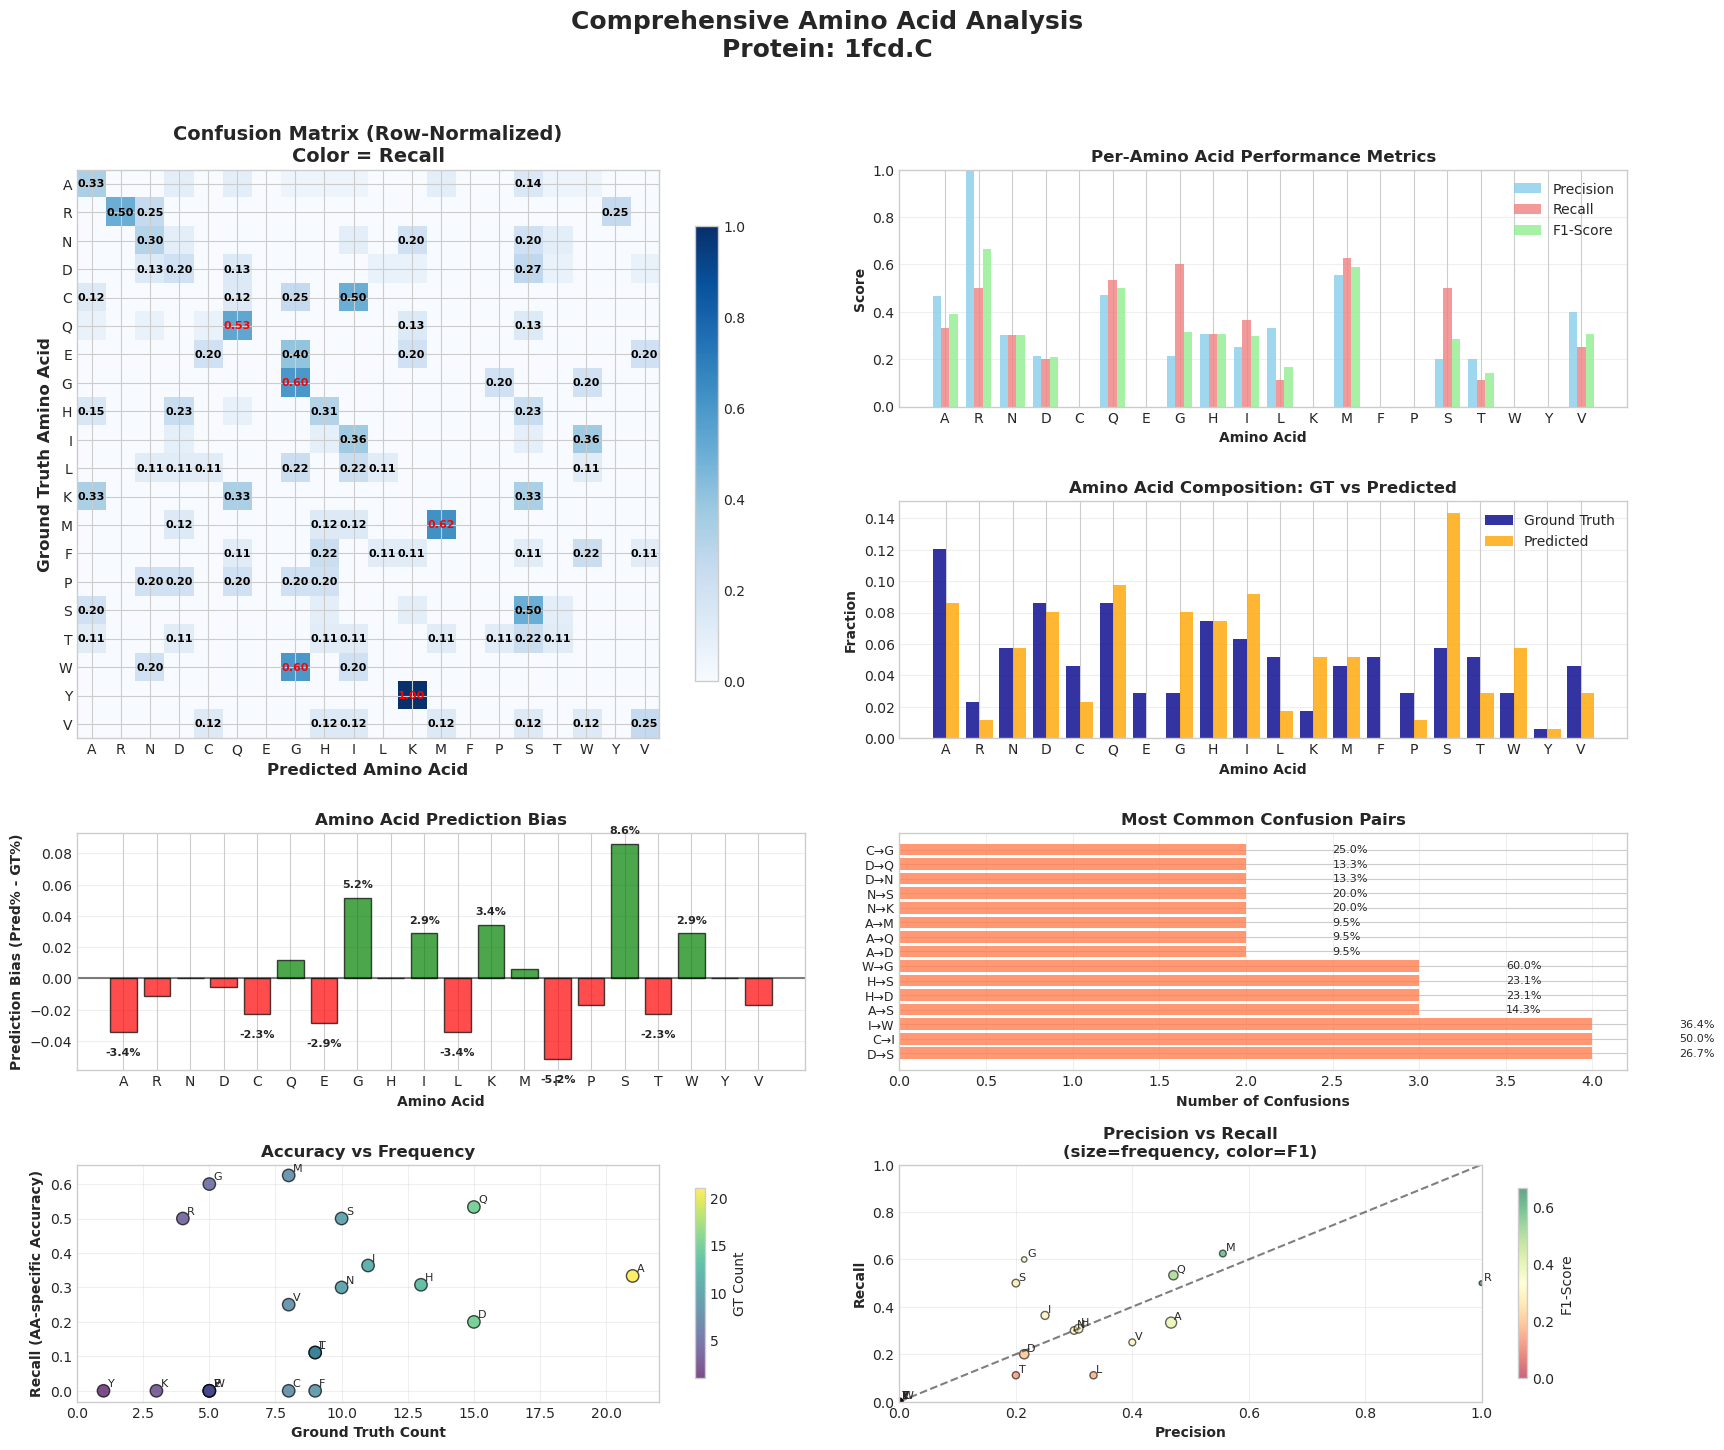

In [28]:
# Create comprehensive visualization
def create_amino_acid_analysis_plots(confusion_mat, aa_stats, gt_composition, pred_composition, aa_names, protein_id):
    """Create comprehensive amino acid analysis visualizations"""
    
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.4, wspace=0.3)
    
    # Plot 1: Confusion Matrix Heatmap
    ax1 = fig.add_subplot(gs[:2, :2])
    
    # Normalize confusion matrix by row (ground truth) to show recall
    confusion_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    confusion_normalized = np.nan_to_num(confusion_normalized)  # Handle division by zero
    
    im1 = ax1.imshow(confusion_normalized, cmap='Blues', aspect='auto')
    ax1.set_xticks(range(20))
    ax1.set_yticks(range(20))
    ax1.set_xticklabels(aa_names)
    ax1.set_yticklabels(aa_names)
    ax1.set_xlabel('Predicted Amino Acid', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Ground Truth Amino Acid', fontweight='bold', fontsize=12)
    ax1.set_title('Confusion Matrix (Row-Normalized)\nColor = Recall', fontweight='bold', fontsize=14)
    
    # Add text annotations for high values
    for i in range(20):
        for j in range(20):
            if confusion_normalized[i, j] > 0.1:
                text = ax1.text(j, i, f'{confusion_normalized[i, j]:.2f}',
                               ha="center", va="center", color="red" if confusion_normalized[i, j] > 0.5 else "black",
                               fontsize=8, fontweight='bold')
    
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Plot 2: Per-AA Performance Metrics
    ax2 = fig.add_subplot(gs[0, 2:])
    
    aa_indices = range(20)
    precision_vals = [aa_stats[aa]['precision'] for aa in aa_names]
    recall_vals = [aa_stats[aa]['recall'] for aa in aa_names]
    f1_vals = [aa_stats[aa]['f1_score'] for aa in aa_names]
    
    x_pos = np.arange(20)
    width = 0.25
    
    bars1 = ax2.bar(x_pos - width, precision_vals, width, label='Precision', alpha=0.8, color='skyblue')
    bars2 = ax2.bar(x_pos, recall_vals, width, label='Recall', alpha=0.8, color='lightcoral')
    bars3 = ax2.bar(x_pos + width, f1_vals, width, label='F1-Score', alpha=0.8, color='lightgreen')
    
    ax2.set_xlabel('Amino Acid', fontweight='bold')
    ax2.set_ylabel('Score', fontweight='bold')
    ax2.set_title('Per-Amino Acid Performance Metrics', fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(aa_names)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_ylim(0, 1)
    
    # Plot 3: Composition Comparison
    ax3 = fig.add_subplot(gs[1, 2:])
    
    gt_fractions = gt_composition / np.sum(gt_composition)
    pred_fractions = pred_composition / np.sum(pred_composition)
    
    x_pos = np.arange(20)
    bars1 = ax3.bar(x_pos - 0.2, gt_fractions, 0.4, label='Ground Truth', alpha=0.8, color='darkblue')
    bars2 = ax3.bar(x_pos + 0.2, pred_fractions, 0.4, label='Predicted', alpha=0.8, color='orange')
    
    ax3.set_xlabel('Amino Acid', fontweight='bold')
    ax3.set_ylabel('Fraction', fontweight='bold')
    ax3.set_title('Amino Acid Composition: GT vs Predicted', fontweight='bold')
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels(aa_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Composition Bias
    ax4 = fig.add_subplot(gs[2, :2])
    
    bias = pred_fractions - gt_fractions
    colors = ['red' if b < 0 else 'green' for b in bias]
    
    bars = ax4.bar(x_pos, bias, color=colors, alpha=0.7, edgecolor='black')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.set_xlabel('Amino Acid', fontweight='bold')
    ax4.set_ylabel('Prediction Bias (Pred% - GT%)', fontweight='bold')
    ax4.set_title('Amino Acid Prediction Bias', fontweight='bold')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(aa_names)
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels for significant biases
    for i, (bar, b) in enumerate(zip(bars, bias)):
        if abs(b) > 0.02:  # Show label if bias > 2%
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + (0.005 if height > 0 else -0.01),
                    f'{b*100:.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                    fontsize=8, fontweight='bold')
    
    # Plot 5: Most Confused Pairs
    ax5 = fig.add_subplot(gs[2, 2:])
    
    # Find top confusion pairs (off-diagonal)
    confusion_pairs = []
    for i in range(20):
        for j in range(20):
            if i != j and confusion_mat[i, j] > 0:
                confusion_pairs.append((aa_names[i], aa_names[j], confusion_mat[i, j], confusion_normalized[i, j]))
    
    # Sort by count and take top 15
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confusions = confusion_pairs[:15]
    
    if len(top_confusions) > 0:
        labels = [f"{pair[0]}→{pair[1]}" for pair in top_confusions]
        counts = [pair[2] for pair in top_confusions]
        rates = [pair[3] for pair in top_confusions]
        
        y_pos = np.arange(len(top_confusions))
        bars = ax5.barh(y_pos, counts, alpha=0.8, color='coral')
        
        ax5.set_yticks(y_pos)
        ax5.set_yticklabels(labels, fontsize=9)
        ax5.set_xlabel('Number of Confusions', fontweight='bold')
        ax5.set_title('Most Common Confusion Pairs', fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='x')
        
        # Add rate labels
        for i, (bar, rate) in enumerate(zip(bars, rates)):
            width = bar.get_width()
            ax5.text(width + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{rate*100:.1f}%', ha='left', va='center', fontsize=8)
    
    # Plot 6: Accuracy by Amino Acid Frequency
    ax6 = fig.add_subplot(gs[3, :2])
    
    gt_counts = [aa_stats[aa]['n_ground_truth'] for aa in aa_names]
    accuracies_by_aa = [aa_stats[aa]['recall'] for aa in aa_names]  # Recall = accuracy for this AA
    
    # Color points by frequency
    scatter = ax6.scatter(gt_counts, accuracies_by_aa, 
                         c=gt_counts, cmap='viridis', s=80, alpha=0.7, edgecolors='black')
    
    # Add amino acid labels
    for i, aa in enumerate(aa_names):
        if gt_counts[i] > 0:  # Only label AAs that appear
            ax6.annotate(aa, (gt_counts[i], accuracies_by_aa[i]), 
                        xytext=(3, 3), textcoords='offset points', fontsize=8)
    
    ax6.set_xlabel('Ground Truth Count', fontweight='bold')
    ax6.set_ylabel('Recall (AA-specific Accuracy)', fontweight='bold')
    ax6.set_title('Accuracy vs Frequency', fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax6, label='GT Count', shrink=0.8)
    
    # Plot 7: Precision-Recall scatter
    ax7 = fig.add_subplot(gs[3, 2:])
    
    precision_vals = np.array(precision_vals)
    recall_vals = np.array(recall_vals)
    
    # Size points by ground truth frequency
    sizes = np.array(gt_counts) * 3  # Scale for visibility
    scatter = ax7.scatter(precision_vals, recall_vals, s=sizes, 
                         alpha=0.6, c=f1_vals, cmap='RdYlGn', edgecolors='black')
    
    # Add amino acid labels
    for i, aa in enumerate(aa_names):
        if gt_counts[i] > 0:
            ax7.annotate(aa, (precision_vals[i], recall_vals[i]), 
                        xytext=(2, 2), textcoords='offset points', fontsize=8)
    
    ax7.set_xlabel('Precision', fontweight='bold')
    ax7.set_ylabel('Recall', fontweight='bold')
    ax7.set_title('Precision vs Recall\n(size=frequency, color=F1)', fontweight='bold')
    ax7.grid(True, alpha=0.3)
    ax7.set_xlim(0, 1)
    ax7.set_ylim(0, 1)
    
    # Add diagonal line
    ax7.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    
    plt.colorbar(scatter, ax=ax7, label='F1-Score', shrink=0.8)
    
    plt.suptitle(f'Comprehensive Amino Acid Analysis\nProtein: {protein_id}', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    return fig

# Create the comprehensive visualization
fig = create_amino_acid_analysis_plots(confusion_mat, aa_stats, gt_composition, 
                                      pred_composition, aa_names, protein_id)
plt.tight_layout()
plt.show()

🎨 Creating Confusion Matrix and Composition Visualizations...


/tmp/ipykernel_2188253/691703753.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


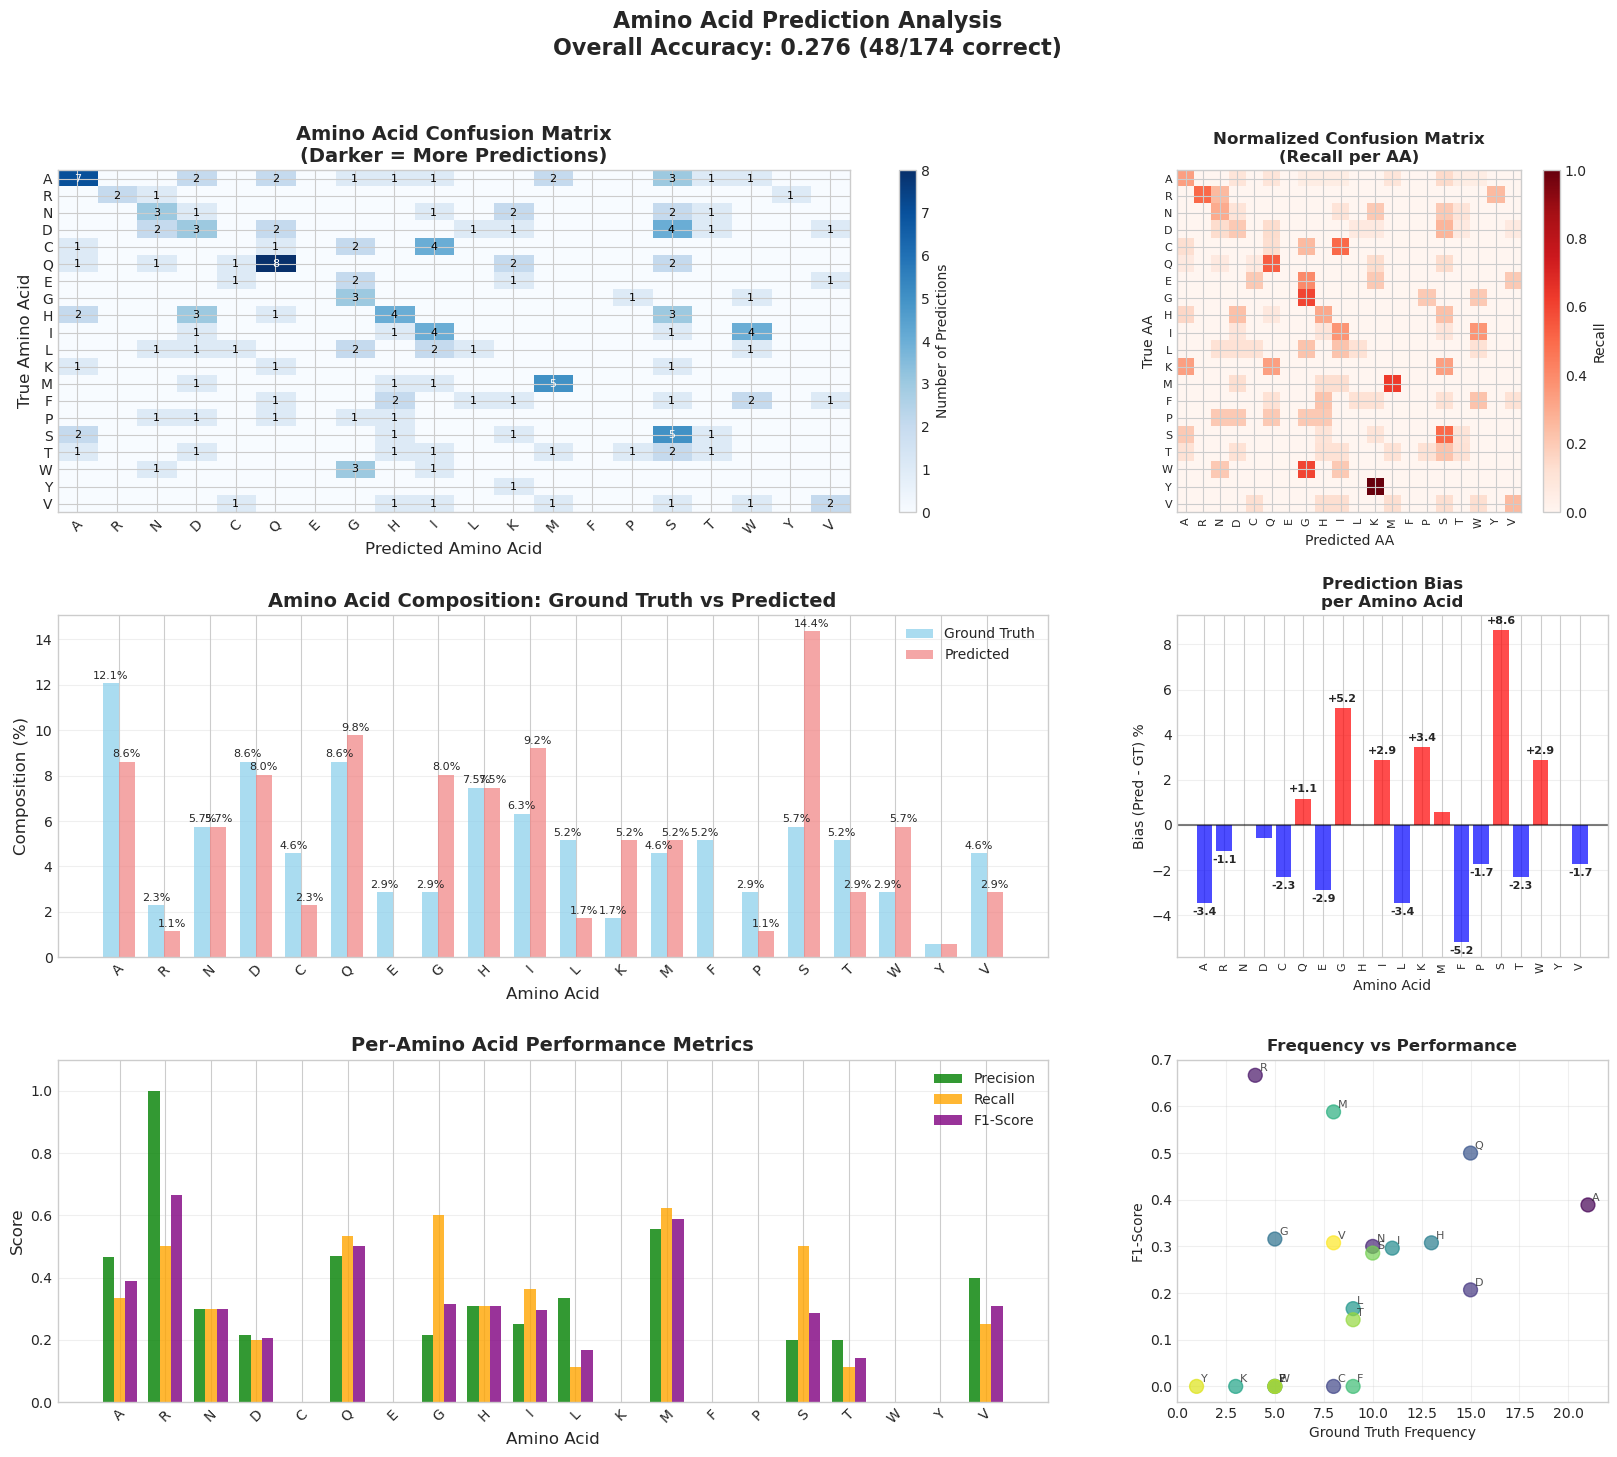


📈 SUMMARY STATISTICS:
   Overall Accuracy: 0.276
   Total positions analyzed: 174
   Correctly predicted: 48
   Number of amino acid types in ground truth: 20
   Number of amino acid types predicted: 18

🏆 BEST PERFORMING AMINO ACID: R (F1: 0.667)
💔 WORST PERFORMING AMINO ACID: C (F1: 0.000)


NameError: name 'most_overped' is not defined

In [30]:
# Comprehensive Confusion Matrix and Composition Visualization
print("🎨 Creating Confusion Matrix and Composition Visualizations...")

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, :2])
im1 = ax1.imshow(confusion_mat, cmap='Blues', aspect='auto')
ax1.set_xlabel('Predicted Amino Acid', fontsize=12)
ax1.set_ylabel('True Amino Acid', fontsize=12)
ax1.set_title('Amino Acid Confusion Matrix\n(Darker = More Predictions)', fontsize=14, fontweight='bold')
ax1.set_xticks(range(20))
ax1.set_yticks(range(20))
ax1.set_xticklabels(aa_names, rotation=45)
ax1.set_yticklabels(aa_names)

# Add colorbar for confusion matrix
plt.colorbar(im1, ax=ax1, label='Number of Predictions')

# Add text annotations to confusion matrix (only for non-zero values)
for i in range(20):
    for j in range(20):
        if confusion_mat[i, j] > 0:
            text_color = 'white' if confusion_mat[i, j] > confusion_mat.max() * 0.5 else 'black'
            ax1.text(j, i, str(confusion_mat[i, j]), 
                    ha='center', va='center', color=text_color, fontsize=8)

# 2. Normalized Confusion Matrix (Recall)
ax2 = fig.add_subplot(gs[0, 2])
# Normalize by rows (true labels) to get recall
normalized_confusion = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
# Handle division by zero
normalized_confusion = np.nan_to_num(normalized_confusion)

im2 = ax2.imshow(normalized_confusion, cmap='Reds', aspect='auto', vmin=0, vmax=1)
ax2.set_xlabel('Predicted AA', fontsize=10)
ax2.set_ylabel('True AA', fontsize=10)
ax2.set_title('Normalized Confusion Matrix\n(Recall per AA)', fontsize=12, fontweight='bold')
ax2.set_xticks(range(20))
ax2.set_yticks(range(20))
ax2.set_xticklabels(aa_names, rotation=90, fontsize=8)
ax2.set_yticklabels(aa_names, fontsize=8)
plt.colorbar(im2, ax=ax2, label='Recall')

# 3. Amino Acid Composition Comparison
ax3 = fig.add_subplot(gs[1, :2])
x_pos = np.arange(len(aa_names))
width = 0.35

# Calculate percentages
gt_percentages = (gt_composition / gt_composition.sum()) * 100
pred_percentages = (pred_composition / pred_composition.sum()) * 100

bars1 = ax3.bar(x_pos - width/2, gt_percentages, width, label='Ground Truth', alpha=0.7, color='skyblue')
bars2 = ax3.bar(x_pos + width/2, pred_percentages, width, label='Predicted', alpha=0.7, color='lightcoral')

ax3.set_xlabel('Amino Acid', fontsize=12)
ax3.set_ylabel('Composition (%)', fontsize=12)
ax3.set_title('Amino Acid Composition: Ground Truth vs Predicted', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(aa_names, rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels on bars (only for bars > 1%)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 1:  # Only label significant bars
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

# 4. Composition Bias (Predicted - Ground Truth)
ax4 = fig.add_subplot(gs[1, 2])
bias = pred_percentages - gt_percentages
colors = ['red' if b > 0 else 'blue' for b in bias]
bars = ax4.bar(range(len(aa_names)), bias, color=colors, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax4.set_xlabel('Amino Acid', fontsize=10)
ax4.set_ylabel('Bias (Pred - GT) %', fontsize=10)
ax4.set_title('Prediction Bias\nper Amino Acid', fontsize=12, fontweight='bold')
ax4.set_xticks(range(len(aa_names)))
ax4.set_xticklabels(aa_names, rotation=90, fontsize=8)
ax4.grid(axis='y', alpha=0.3)

# Add value labels for significant biases
for i, (bar, b) in enumerate(zip(bars, bias)):
    if abs(b) > 1:  # Only label significant biases
        ax4.text(bar.get_x() + bar.get_width()/2., 
                b + (0.2 if b > 0 else -0.2),
                f'{b:+.1f}', ha='center', va='bottom' if b > 0 else 'top', 
                fontsize=8, fontweight='bold')

# 5. Per-Amino Acid Performance Metrics
ax5 = fig.add_subplot(gs[2, :2])
aa_list = []
precision_list = []
recall_list = []
f1_list = []

for aa in aa_names:
    stats = aa_stats[aa]
    if stats['n_ground_truth'] > 0 or stats['n_predicted'] > 0:  # Only include AAs that appear
        aa_list.append(aa)
        precision_list.append(stats['precision'])
        recall_list.append(stats['recall'])
        f1_list.append(stats['f1_score'])

x_pos = np.arange(len(aa_list))
width = 0.25

bars1 = ax5.bar(x_pos - width, precision_list, width, label='Precision', alpha=0.8, color='green')
bars2 = ax5.bar(x_pos, recall_list, width, label='Recall', alpha=0.8, color='orange')
bars3 = ax5.bar(x_pos + width, f1_list, width, label='F1-Score', alpha=0.8, color='purple')

ax5.set_xlabel('Amino Acid', fontsize=12)
ax5.set_ylabel('Score', fontsize=12)
ax5.set_title('Per-Amino Acid Performance Metrics', fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(aa_list, rotation=45)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim(0, 1.1)

# 6. Frequency vs Performance Scatter
ax6 = fig.add_subplot(gs[2, 2])
frequencies = [aa_stats[aa]['n_ground_truth'] for aa in aa_names]
f1_scores = [aa_stats[aa]['f1_score'] for aa in aa_names]

scatter = ax6.scatter(frequencies, f1_scores, alpha=0.7, s=100, c=range(len(aa_names)), cmap='viridis')
ax6.set_xlabel('Ground Truth Frequency', fontsize=10)
ax6.set_ylabel('F1-Score', fontsize=10)
ax6.set_title('Frequency vs Performance', fontsize=12, fontweight='bold')
ax6.grid(alpha=0.3)

# Add amino acid labels to scatter points
for i, aa in enumerate(aa_names):
    if frequencies[i] > 0:  # Only label AAs that appear
        ax6.annotate(aa, (frequencies[i], f1_scores[i]), 
                    xytext=(3, 3), textcoords='offset points', 
                    fontsize=8, alpha=0.8)

# Add main title and summary statistics
overall_accuracy = np.trace(confusion_mat) / confusion_mat.sum()
fig.suptitle(f'Amino Acid Prediction Analysis\n'
            f'Overall Accuracy: {overall_accuracy:.3f} ({np.trace(confusion_mat)}/{confusion_mat.sum()} correct)',
            fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"   Overall Accuracy: {overall_accuracy:.3f}")
print(f"   Total positions analyzed: {confusion_mat.sum()}")
print(f"   Correctly predicted: {np.trace(confusion_mat)}")
print(f"   Number of amino acid types in ground truth: {len(np.unique(ground_truth_indices))}")
print(f"   Number of amino acid types predicted: {len(np.unique(predicted_aa))}")

# Find best and worst performing amino acids
best_aa = max(aa_names, key=lambda aa: aa_stats[aa]['f1_score'] if aa_stats[aa]['n_ground_truth'] > 0 else -1)
worst_aa = min([aa for aa in aa_names if aa_stats[aa]['n_ground_truth'] > 0], 
               key=lambda aa: aa_stats[aa]['f1_score'])

print(f"\n🏆 BEST PERFORMING AMINO ACID: {best_aa} (F1: {aa_stats[best_aa]['f1_score']:.3f})")
print(f"💔 WORST PERFORMING AMINO ACID: {worst_aa} (F1: {aa_stats[worst_aa]['f1_score']:.3f})")

# Find most biased amino acids
most_overpred = max(aa_names, key=lambda aa: (pred_composition[aa_names.index(aa)] - gt_composition[aa_names.index(aa)]))
most_underpred = min(aa_names, key=lambda aa: (pred_composition[aa_names.index(aa)] - gt_composition[aa_names.index(aa)]))

print(f"\n📈 MOST OVER-PREDICTED: {most_overpred} (+{pred_composition[aa_names.index(most_overpred)] - gt_composition[aa_names.index(most_overpred)]} positions)")
print(f"📉 MOST UNDER-PREDICTED: {most_underpred} ({pred_composition[aa_names.index(most_underpred)] - gt_composition[aa_names.index(most_underpred)]} positions)")